In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import os
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check and set up GPU
def setup_gpu(gpu_index=1):
    # Check total number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Total GPUs available: {num_gpus}")
    
    # Print all GPU names
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Validate requested GPU index
    if gpu_index >= num_gpus:
        print(f"Warning: Requested GPU {gpu_index} not available. Using GPU 0.")
        gpu_index = 0
    
    # Set the specific GPU
    torch.cuda.set_device(gpu_index)
    device = torch.device(f'cuda:{gpu_index}')
    
    print(f"\n🚀 Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
    return device

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Optional: for deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setup device and seed
set_seed(42)
device = setup_gpu(gpu_index=1)  # Explicitly use GPU 1

# Print system information
print(f"PyTorch Version: {torch.__version__}")
print(f"TIMM Version: {timm.__version__}")

# Model hyperparameters
HYPERPARAMS = {
    'model_name': 'convnext_tiny.fb_in22k_ft_in1k',
    'input_shape': (160, 160, 3),
    'num_classes': 2,
    'batch_size': 64,
    'epochs': 60,
    'learning_rate': 1e-4,
    'learning_rate_decay': 0.2,
    'patience_lr': 5,
    'patience_early_stop': 9,
    'validation_split': 0.1,
    'test_split': 0.1,
    'label_smoothing': 0.2,
    'epsilon': 1e-6,
    'weight_decay': 0.01,
    'random_state': 42
}

# Dataset paths
DATASET_PATH = Path('datasets_paper/2_class_dataset')
MODEL_SAVE_PATH = Path('models/2_class_pytorch')
RESULTS_PATH = Path('results/2_class_pytorch')

# Create directories
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("\n2-Class Classification Setup:")
for key, value in HYPERPARAMS.items():
    print(f"  {key}: {value}")

Total GPUs available: 2
GPU 0: NVIDIA GeForce RTX 2080 Ti
GPU 1: NVIDIA GeForce RTX 2080 Ti

🚀 Using GPU 1: NVIDIA GeForce RTX 2080 Ti
PyTorch Version: 2.7.1+cu118
TIMM Version: 1.0.16

2-Class Classification Setup:
  model_name: convnext_tiny.fb_in22k_ft_in1k
  input_shape: (160, 160, 3)
  num_classes: 2
  batch_size: 64
  epochs: 60
  learning_rate: 0.0001
  learning_rate_decay: 0.2
  patience_lr: 5
  patience_early_stop: 9
  validation_split: 0.1
  test_split: 0.1
  label_smoothing: 0.2
  epsilon: 1e-06
  weight_decay: 0.01
  random_state: 42


In [2]:
# Data transforms and dataset loading for 2-Class Solar PV Anomaly Detection
train_transform = transforms.Compose([
    transforms.Resize((HYPERPARAMS['input_shape'][0], HYPERPARAMS['input_shape'][1])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((HYPERPARAMS['input_shape'][0], HYPERPARAMS['input_shape'][1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load original dataset without transform first to prevent data leakage
full_dataset = ImageFolder(root=DATASET_PATH)
print(f"📊 2-Class Solar PV Dataset Info:")
print(f"Total samples: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")
print(f"Number of classes: {len(full_dataset.classes)}")

# Verify we have exactly 2 classes for binary classification
assert len(full_dataset.classes) == 2, f"Expected 2 classes for binary classification, got {len(full_dataset.classes)}"
print(f"✅ Confirmed 2-class binary classification setup")

# Get labels for stratified split
all_labels = [full_dataset.targets[i] for i in range(len(full_dataset))]

# Calculate dataset splits
total_size = len(full_dataset)
test_size = HYPERPARAMS['test_split']
val_size = HYPERPARAMS['validation_split']

print(f"\n2-Class Dataset splits:")
print(f"  Train: {1 - test_size - val_size:.1%} of total")
print(f"  Validation: {val_size:.1%} of total")
print(f"  Test: {test_size:.1%} of total")

# Use StratifiedShuffleSplit for stratified splits
from sklearn.model_selection import StratifiedShuffleSplit

# First split: separate test set
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
temp_indices, test_indices = next(sss_test.split(range(len(full_dataset)), all_labels))

# Second split: separate train and validation from remaining data
temp_labels = [all_labels[i] for i in temp_indices]
val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size for remaining data

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size_adjusted, random_state=42)
train_indices, val_indices = next(sss_val.split(temp_indices, temp_labels))

# Convert to actual indices
train_indices = [temp_indices[i] for i in train_indices]
val_indices = [temp_indices[i] for i in val_indices]

print(f"\nActual 2-class dataset splits:")
print(f"  Train: {len(train_indices)} samples ({len(train_indices)/total_size*100:.1f}%)")
print(f"  Validation: {len(val_indices)} samples ({len(val_indices)/total_size*100:.1f}%)")
print(f"  Test: {len(test_indices)} samples ({len(test_indices)/total_size*100:.1f}%)")

# Verify stratification by checking class distribution for binary classification
print(f"\n2-Class distribution verification:")
for split_name, indices in [("Train", train_indices), ("Val", val_indices), ("Test", test_indices)]:
    split_labels = [all_labels[i] for i in indices]
    class_counts = {}
    for label in split_labels:
        class_name = full_dataset.classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    # Calculate percentages for binary classification
    total_split = len(split_labels)
    class_percentages = {k: f"{v} ({v/total_split*100:.1f}%)" for k, v in class_counts.items()}
    print(f"  {split_name}: {dict(sorted(class_percentages.items()))}")

# Create separate datasets with appropriate transforms
train_dataset = torch.utils.data.Subset(
    ImageFolder(root=DATASET_PATH, transform=train_transform),
    train_indices
)

val_dataset = torch.utils.data.Subset(
    ImageFolder(root=DATASET_PATH, transform=val_test_transform),
    val_indices
)

test_dataset = torch.utils.data.Subset(
    ImageFolder(root=DATASET_PATH, transform=val_test_transform),
    test_indices
)

# Create data loaders for 2-class classification
train_loader = DataLoader(
    train_dataset,
    batch_size=HYPERPARAMS['batch_size'],
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues on Windows
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=HYPERPARAMS['batch_size'],
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues on Windows
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=HYPERPARAMS['batch_size'],
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues on Windows
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n2-Class Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Explanation for validation batch count
print(f"\n📝 Validation batch count explanation:")
print(f"  Validation samples: {len(val_indices)}")
print(f"  Batch size: {HYPERPARAMS['batch_size']}")
print(f"  Batches needed: {len(val_indices)} ÷ {HYPERPARAMS['batch_size']} = {len(val_indices) / HYPERPARAMS['batch_size']:.2f}")
print(f"  Rounded up to: {len(val_loader)} batches (last batch has {len(val_indices) % HYPERPARAMS['batch_size']} samples)")


📊 2-Class Solar PV Dataset Info:
Total samples: 40000
Classes: ['Anomaly', 'No-Anomaly']
Number of classes: 2
✅ Confirmed 2-class binary classification setup

2-Class Dataset splits:
  Train: 80.0% of total
  Validation: 10.0% of total
  Test: 10.0% of total

Actual 2-class dataset splits:
  Train: 31999 samples (80.0%)
  Validation: 4001 samples (10.0%)
  Test: 4000 samples (10.0%)

2-Class distribution verification:
  Train: {'Anomaly': '15999 (50.0%)', 'No-Anomaly': '16000 (50.0%)'}
  Val: {'Anomaly': '2001 (50.0%)', 'No-Anomaly': '2000 (50.0%)'}
  Test: {'Anomaly': '2000 (50.0%)', 'No-Anomaly': '2000 (50.0%)'}

2-Class Data loaders created:
  Train batches: 500
  Validation batches: 63
  Test batches: 63

📝 Validation batch count explanation:
  Validation samples: 4001
  Batch size: 64
  Batches needed: 4001 ÷ 64 = 62.52
  Rounded up to: 63 batches (last batch has 33 samples)


In [3]:
# Custom ConvNeXt Classifier using TIMM for 2-Class Solar PV Anomaly Detection
class ConvNeXtClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, dropout_rate=0.3):
        super(ConvNeXtClassifier, self).__init__()
        
        # Load pre-trained ConvNeXt-Tiny from TIMM
        self.backbone = timm.create_model(
            'convnext_tiny.fb_in22k_ft_in1k',  # ConvNeXt-Tiny pretrained on ImageNet-22k and fine-tuned on ImageNet-1k
            pretrained=pretrained,
            num_classes=0  # Remove head, we'll add custom one
        )
        
        # Get the feature dimension
        self.feature_dim = self.backbone.num_features  # 768 for ConvNeXt-Tiny
        
        # Custom classification head for 2-class classification (Anomaly vs No-Anomaly)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 256),  # Reduced from 512 for binary classification
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)  # 2 classes: Anomaly, No-Anomaly
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Extract features using ConvNeXt backbone
        features = self.backbone(x)
        
        # Apply classification head
        output = self.classifier(features)
        
        return output

# Create model for 2-class solar PV anomaly detection
model = ConvNeXtClassifier(num_classes=HYPERPARAMS['num_classes']).to(device)

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"🔧 2-Class Solar PV Anomaly Detection Model:")
print(f"  Model: ConvNeXt-Tiny with custom binary classification head")
print(f"  Input size: {HYPERPARAMS['input_shape']}")
print(f"  Backbone: convnext_tiny.fb_in22k_ft_in1k")
print(f"  Hidden dimension: 768")
print(f"  Classes: {HYPERPARAMS['num_classes']} (Anomaly, No-Anomaly)")
print(f"  Total trainable parameters: {total_params:,}")

# Print model structure
print(f"\n📋 Model Structure:")
print(model)


🔧 2-Class Solar PV Anomaly Detection Model:
  Model: ConvNeXt-Tiny with custom binary classification head
  Input size: (160, 160, 3)
  Backbone: convnext_tiny.fb_in22k_ft_in1k
  Hidden dimension: 768
  Classes: 2 (Anomaly, No-Anomaly)
  Total trainable parameters: 28,017,506

📋 Model Structure:
ConvNeXtClassifier(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
       

In [4]:
# Label Smoothing CrossEntropy Loss for 2-Class Solar PV Anomaly Detection
class LabelSmoothingCrossEntropy(nn.Module):
    """
    Label Smoothing CrossEntropy Loss for binary classification
    Helps prevent overconfident predictions in Anomaly vs No-Anomaly classification
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        logprobs = torch.nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Loss function and optimizer for 2-class solar PV anomaly detection
criterion = LabelSmoothingCrossEntropy(smoothing=HYPERPARAMS['label_smoothing'])
optimizer = optim.AdamW(
    model.parameters(),
    lr=HYPERPARAMS['learning_rate'],
    weight_decay=HYPERPARAMS['weight_decay'],
    eps=HYPERPARAMS['epsilon']
)

# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=HYPERPARAMS['learning_rate_decay'],
    patience=HYPERPARAMS['patience_lr']
)

print("🎯 2-Class Solar PV Anomaly Detection Training Configuration:")
print(f"  Task: Binary classification (Anomaly vs No-Anomaly)")
print(f"  Loss: CrossEntropy with Label Smoothing ({HYPERPARAMS['label_smoothing']})")
print(f"  Optimizer: AdamW (lr={HYPERPARAMS['learning_rate']}, weight_decay={HYPERPARAMS['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (factor={HYPERPARAMS['learning_rate_decay']}, patience={HYPERPARAMS['patience_lr']})")
print(f"  Early stopping patience: {HYPERPARAMS['patience_early_stop']} epochs")
print(f"  Data split: StratifiedShuffleSplit for balanced binary class distribution")
print(f"  Classes: 2 (Anomaly, No-Anomaly)")


🎯 2-Class Solar PV Anomaly Detection Training Configuration:
  Task: Binary classification (Anomaly vs No-Anomaly)
  Loss: CrossEntropy with Label Smoothing (0.2)
  Optimizer: AdamW (lr=0.0001, weight_decay=0.01)
  Scheduler: ReduceLROnPlateau (factor=0.2, patience=5)
  Early stopping patience: 9 epochs
  Data split: StratifiedShuffleSplit for balanced binary class distribution
  Classes: 2 (Anomaly, No-Anomaly)


In [5]:
# Training and validation functions for 2-Class Solar PV Anomaly Detection
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Training function for binary classification (Anomaly vs No-Anomaly)
    Optimized for solar PV thermal image anomaly detection
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training Binary Classification', leave=False)
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%',
            'Classes': '2 (Anomaly/No-Anomaly)'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validation function for binary solar PV anomaly classification
    Evaluates model performance on Anomaly vs No-Anomaly detection
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validating Binary Classification', leave=False)
        
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%',
                'Task': 'Binary Anomaly Detection'
            })
    
    epoch_loss = val_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("✅ 2-Class Solar PV Anomaly Detection training functions defined")
print("🎯 Task: Binary classification for thermal image anomaly detection")
print("📊 Classes: Anomaly vs No-Anomaly")
print("🔧 Compatible with StratifiedShuffleSplit for balanced binary class distribution")


✅ 2-Class Solar PV Anomaly Detection training functions defined
🎯 Task: Binary classification for thermal image anomaly detection
📊 Classes: Anomaly vs No-Anomaly
🔧 Compatible with StratifiedShuffleSplit for balanced binary class distribution


In [6]:
# Training loop with early stopping for 2-Class Solar PV Anomaly Detection
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, patience, device, save_path):
    """
    Training function for binary solar PV anomaly classification
    Optimized for Anomaly vs No-Anomaly detection task
    """
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    start_time = datetime.now()
    
    print(f"🚀 Starting 2-Class Solar PV Anomaly Detection training for {num_epochs} epochs...")
    print(f"📅 Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"🎯 Task: Binary classification (Anomaly vs No-Anomaly)")
    print("-" * 80)
    
    for epoch in range(num_epochs):
        epoch_start = datetime.now()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nEpoch {epoch+1}/{num_epochs} | LR: {current_lr:.2e}")
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        
        # Calculate epoch time
        epoch_time = datetime.now() - epoch_start
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"Time: {epoch_time.total_seconds():.1f}s")
        
        # Check for best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            
            # Save best model for 2-class classification
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'hyperparams': HYPERPARAMS,
                'task': '2-class_binary_anomaly_detection',
                'classes': ['Anomaly', 'No-Anomaly']
            }, save_path / 'best_convnext_2class.pth')
            
            print(f"✅ New best model saved! (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"⏳ Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered after {epoch + 1} epochs")
            print(f"Best validation loss: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)")
            break
    
    total_time = datetime.now() - start_time
    print(f"\n🏁 2-Class Solar PV Anomaly Detection training completed!")
    print(f"⏱️  Total time: {total_time}")
    print(f"🎯 Best validation accuracy: {best_val_acc:.2f}%")
    print(f"📊 Binary classification performance on thermal images")
    
    return history

print("✅ 2-Class training function defined")
print("📝 Note: Optimized for binary solar PV anomaly detection with StratifiedShuffleSplit")
print("🔧 Compatible with Anomaly vs No-Anomaly classification task")


✅ 2-Class training function defined
📝 Note: Optimized for binary solar PV anomaly detection with StratifiedShuffleSplit
🔧 Compatible with Anomaly vs No-Anomaly classification task


In [7]:
# Start training with StratifiedShuffleSplit
print("🎯 Starting 2-Class ConvNeXt Training with StratifiedShuffleSplit...")
print(f"📊 Dataset: {len(full_dataset.classes)} classes, {len(full_dataset)} total images")
print(f"🏗️  Model: ConvNeXt-Tiny with {count_parameters(model):,} parameters")
print(f"🔄 Using StratifiedShuffleSplit for balanced train/validation splits")

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=HYPERPARAMS['epochs'],
    patience=HYPERPARAMS['patience_early_stop'],
    device=device,
    save_path=MODEL_SAVE_PATH
)


🎯 Starting 2-Class ConvNeXt Training with StratifiedShuffleSplit...
📊 Dataset: 2 classes, 40000 total images
🏗️  Model: ConvNeXt-Tiny with 28,017,506 parameters
🔄 Using StratifiedShuffleSplit for balanced train/validation splits
🚀 Starting 2-Class Solar PV Anomaly Detection training for 60 epochs...
📅 Start time: 2025-07-06 01:37:10
🎯 Task: Binary classification (Anomaly vs No-Anomaly)
--------------------------------------------------------------------------------

Epoch 1/60 | LR: 1.00e-04


Train Loss: 0.4744 | Train Acc: 86.89%
Val Loss:   0.4306 | Val Acc:   91.15%
Time: 242.9s
✅ New best model saved! (Val Loss: 0.4306)

Epoch 2/60 | LR: 1.00e-04


Train Loss: 0.4231 | Train Acc: 92.08%
Val Loss:   0.4292 | Val Acc:   91.88%
Time: 238.6s
✅ New best model saved! (Val Loss: 0.4292)

Epoch 3/60 | LR: 1.00e-04


Train Loss: 0.4024 | Train Acc: 93.97%
Val Loss:   0.3916 | Val Acc:   94.45%
Time: 235.2s
✅ New best model saved! (Val Loss: 0.3916)

Epoch 4/60 | LR: 1.00e-04


Train Loss: 0.3883 | Train Acc: 95.03%
Val Loss:   0.3867 | Val Acc:   94.65%
Time: 240.2s
✅ New best model saved! (Val Loss: 0.3867)

Epoch 5/60 | LR: 1.00e-04


Train Loss: 0.3792 | Train Acc: 95.86%
Val Loss:   0.3738 | Val Acc:   96.25%
Time: 239.0s
✅ New best model saved! (Val Loss: 0.3738)

Epoch 6/60 | LR: 1.00e-04


Train Loss: 0.3709 | Train Acc: 96.54%
Val Loss:   0.3712 | Val Acc:   96.48%
Time: 240.6s
✅ New best model saved! (Val Loss: 0.3712)

Epoch 7/60 | LR: 1.00e-04


Train Loss: 0.3640 | Train Acc: 97.09%
Val Loss:   0.3693 | Val Acc:   96.40%
Time: 236.3s
✅ New best model saved! (Val Loss: 0.3693)

Epoch 8/60 | LR: 1.00e-04


Train Loss: 0.3585 | Train Acc: 97.48%
Val Loss:   0.3733 | Val Acc:   96.13%
Time: 237.3s
⏳ Patience: 1/9

Epoch 9/60 | LR: 1.00e-04


Train Loss: 0.3537 | Train Acc: 97.83%
Val Loss:   0.3673 | Val Acc:   96.90%
Time: 237.1s
✅ New best model saved! (Val Loss: 0.3673)

Epoch 10/60 | LR: 1.00e-04


Train Loss: 0.3523 | Train Acc: 98.00%
Val Loss:   0.3656 | Val Acc:   96.95%
Time: 236.0s
✅ New best model saved! (Val Loss: 0.3656)

Epoch 11/60 | LR: 1.00e-04


Train Loss: 0.3482 | Train Acc: 98.28%
Val Loss:   0.3658 | Val Acc:   96.83%
Time: 242.4s
⏳ Patience: 1/9

Epoch 12/60 | LR: 1.00e-04


Train Loss: 0.3466 | Train Acc: 98.37%
Val Loss:   0.3664 | Val Acc:   96.98%
Time: 236.6s
⏳ Patience: 2/9

Epoch 13/60 | LR: 1.00e-04


Train Loss: 0.3456 | Train Acc: 98.51%
Val Loss:   0.3544 | Val Acc:   97.75%
Time: 238.9s
✅ New best model saved! (Val Loss: 0.3544)

Epoch 14/60 | LR: 1.00e-04


Train Loss: 0.3432 | Train Acc: 98.72%
Val Loss:   0.3530 | Val Acc:   97.83%
Time: 239.3s
✅ New best model saved! (Val Loss: 0.3530)

Epoch 15/60 | LR: 1.00e-04


Train Loss: 0.3418 | Train Acc: 98.80%
Val Loss:   0.3563 | Val Acc:   97.50%
Time: 242.4s
⏳ Patience: 1/9

Epoch 16/60 | LR: 1.00e-04


Train Loss: 0.3414 | Train Acc: 98.82%
Val Loss:   0.3630 | Val Acc:   97.15%
Time: 239.1s
⏳ Patience: 2/9

Epoch 17/60 | LR: 1.00e-04


Train Loss: 0.3415 | Train Acc: 98.83%
Val Loss:   0.3662 | Val Acc:   96.88%
Time: 239.3s
⏳ Patience: 3/9

Epoch 18/60 | LR: 1.00e-04


Train Loss: 0.3392 | Train Acc: 98.98%
Val Loss:   0.3577 | Val Acc:   97.60%
Time: 238.7s
⏳ Patience: 4/9

Epoch 19/60 | LR: 1.00e-04


Train Loss: 0.3379 | Train Acc: 99.08%
Val Loss:   0.3566 | Val Acc:   97.65%
Time: 237.2s
⏳ Patience: 5/9

Epoch 20/60 | LR: 1.00e-04


Train Loss: 0.3374 | Train Acc: 99.14%
Val Loss:   0.3514 | Val Acc:   98.15%
Time: 237.7s
✅ New best model saved! (Val Loss: 0.3514)

Epoch 21/60 | LR: 1.00e-04


Train Loss: 0.3372 | Train Acc: 99.16%
Val Loss:   0.3594 | Val Acc:   97.45%
Time: 236.2s
⏳ Patience: 1/9

Epoch 22/60 | LR: 1.00e-04


Train Loss: 0.3384 | Train Acc: 99.05%
Val Loss:   0.3546 | Val Acc:   97.90%
Time: 236.4s
⏳ Patience: 2/9

Epoch 23/60 | LR: 1.00e-04


Train Loss: 0.3364 | Train Acc: 99.19%
Val Loss:   0.3487 | Val Acc:   98.20%
Time: 236.7s
✅ New best model saved! (Val Loss: 0.3487)

Epoch 24/60 | LR: 1.00e-04


Train Loss: 0.3356 | Train Acc: 99.28%
Val Loss:   0.3551 | Val Acc:   97.68%
Time: 242.1s
⏳ Patience: 1/9

Epoch 25/60 | LR: 1.00e-04


Train Loss: 0.3365 | Train Acc: 99.25%
Val Loss:   0.3554 | Val Acc:   97.85%
Time: 242.3s
⏳ Patience: 2/9

Epoch 26/60 | LR: 1.00e-04


Train Loss: 0.3363 | Train Acc: 99.27%
Val Loss:   0.3618 | Val Acc:   97.38%
Time: 241.5s
⏳ Patience: 3/9

Epoch 27/60 | LR: 1.00e-04


Train Loss: 0.3356 | Train Acc: 99.29%
Val Loss:   0.3580 | Val Acc:   97.68%
Time: 236.9s
⏳ Patience: 4/9

Epoch 28/60 | LR: 1.00e-04


Train Loss: 0.3347 | Train Acc: 99.34%
Val Loss:   0.3551 | Val Acc:   97.63%
Time: 237.7s
⏳ Patience: 5/9

Epoch 29/60 | LR: 1.00e-04


Train Loss: 0.3337 | Train Acc: 99.41%
Val Loss:   0.3564 | Val Acc:   97.88%
Time: 237.4s
⏳ Patience: 6/9

Epoch 30/60 | LR: 2.00e-05


Train Loss: 0.3293 | Train Acc: 99.76%
Val Loss:   0.3478 | Val Acc:   98.38%
Time: 241.4s
✅ New best model saved! (Val Loss: 0.3478)

Epoch 31/60 | LR: 2.00e-05


Train Loss: 0.3280 | Train Acc: 99.87%
Val Loss:   0.3475 | Val Acc:   98.40%
Time: 240.2s
✅ New best model saved! (Val Loss: 0.3475)

Epoch 32/60 | LR: 2.00e-05


Train Loss: 0.3278 | Train Acc: 99.87%
Val Loss:   0.3472 | Val Acc:   98.45%
Time: 239.6s
✅ New best model saved! (Val Loss: 0.3472)

Epoch 33/60 | LR: 2.00e-05


Train Loss: 0.3275 | Train Acc: 99.90%
Val Loss:   0.3461 | Val Acc:   98.53%
Time: 238.6s
✅ New best model saved! (Val Loss: 0.3461)

Epoch 34/60 | LR: 2.00e-05


Train Loss: 0.3274 | Train Acc: 99.92%
Val Loss:   0.3473 | Val Acc:   98.53%
Time: 237.8s
⏳ Patience: 1/9

Epoch 35/60 | LR: 2.00e-05


Train Loss: 0.3274 | Train Acc: 99.91%
Val Loss:   0.3465 | Val Acc:   98.55%
Time: 236.4s
⏳ Patience: 2/9

Epoch 36/60 | LR: 2.00e-05


Train Loss: 0.3277 | Train Acc: 99.89%
Val Loss:   0.3449 | Val Acc:   98.70%
Time: 238.5s
✅ New best model saved! (Val Loss: 0.3449)

Epoch 37/60 | LR: 2.00e-05


Train Loss: 0.3272 | Train Acc: 99.91%
Val Loss:   0.3485 | Val Acc:   98.40%
Time: 241.6s
⏳ Patience: 1/9

Epoch 38/60 | LR: 2.00e-05


Train Loss: 0.3273 | Train Acc: 99.91%
Val Loss:   0.3488 | Val Acc:   98.48%
Time: 241.2s
⏳ Patience: 2/9

Epoch 39/60 | LR: 2.00e-05


Train Loss: 0.3274 | Train Acc: 99.91%
Val Loss:   0.3484 | Val Acc:   98.40%
Time: 240.1s
⏳ Patience: 3/9

Epoch 40/60 | LR: 2.00e-05


Train Loss: 0.3272 | Train Acc: 99.91%
Val Loss:   0.3483 | Val Acc:   98.40%
Time: 240.4s
⏳ Patience: 4/9

Epoch 41/60 | LR: 2.00e-05


Train Loss: 0.3270 | Train Acc: 99.93%
Val Loss:   0.3483 | Val Acc:   98.48%
Time: 239.9s
⏳ Patience: 5/9

Epoch 42/60 | LR: 2.00e-05


Train Loss: 0.3271 | Train Acc: 99.92%
Val Loss:   0.3461 | Val Acc:   98.65%
Time: 240.2s
⏳ Patience: 6/9

Epoch 43/60 | LR: 4.00e-06


Train Loss: 0.3267 | Train Acc: 99.96%
Val Loss:   0.3456 | Val Acc:   98.73%
Time: 240.8s
⏳ Patience: 7/9

Epoch 44/60 | LR: 4.00e-06


Train Loss: 0.3270 | Train Acc: 99.92%
Val Loss:   0.3442 | Val Acc:   98.78%
Time: 241.1s
✅ New best model saved! (Val Loss: 0.3442)

Epoch 45/60 | LR: 4.00e-06


Train Loss: 0.3267 | Train Acc: 99.95%
Val Loss:   0.3457 | Val Acc:   98.68%
Time: 241.7s
⏳ Patience: 1/9

Epoch 46/60 | LR: 4.00e-06


Train Loss: 0.3267 | Train Acc: 99.96%
Val Loss:   0.3458 | Val Acc:   98.63%
Time: 240.5s
⏳ Patience: 2/9

Epoch 47/60 | LR: 4.00e-06


Train Loss: 0.3266 | Train Acc: 99.96%
Val Loss:   0.3458 | Val Acc:   98.63%
Time: 238.6s
⏳ Patience: 3/9

Epoch 48/60 | LR: 4.00e-06


Train Loss: 0.3267 | Train Acc: 99.96%
Val Loss:   0.3453 | Val Acc:   98.68%
Time: 256.3s
⏳ Patience: 4/9

Epoch 49/60 | LR: 4.00e-06


Train Loss: 0.3267 | Train Acc: 99.96%
Val Loss:   0.3450 | Val Acc:   98.70%
Time: 247.3s
⏳ Patience: 5/9

Epoch 50/60 | LR: 4.00e-06


Train Loss: 0.3266 | Train Acc: 99.96%
Val Loss:   0.3447 | Val Acc:   98.70%
Time: 235.7s
⏳ Patience: 6/9

Epoch 51/60 | LR: 8.00e-07


Train Loss: 0.3265 | Train Acc: 99.97%
Val Loss:   0.3448 | Val Acc:   98.70%
Time: 234.4s
⏳ Patience: 7/9

Epoch 52/60 | LR: 8.00e-07


Train Loss: 0.3265 | Train Acc: 99.97%
Val Loss:   0.3448 | Val Acc:   98.70%
Time: 236.2s
⏳ Patience: 8/9

Epoch 53/60 | LR: 8.00e-07


Train Loss: 0.3265 | Train Acc: 99.97%
Val Loss:   0.3448 | Val Acc:   98.70%
Time: 235.5s
⏳ Patience: 9/9

🛑 Early stopping triggered after 53 epochs
Best validation loss: 0.3442 (Acc: 98.78%)

🏁 2-Class Solar PV Anomaly Detection training completed!
⏱️  Total time: 3:31:36.286699
🎯 Best validation accuracy: 98.78%
📊 Binary classification performance on thermal images


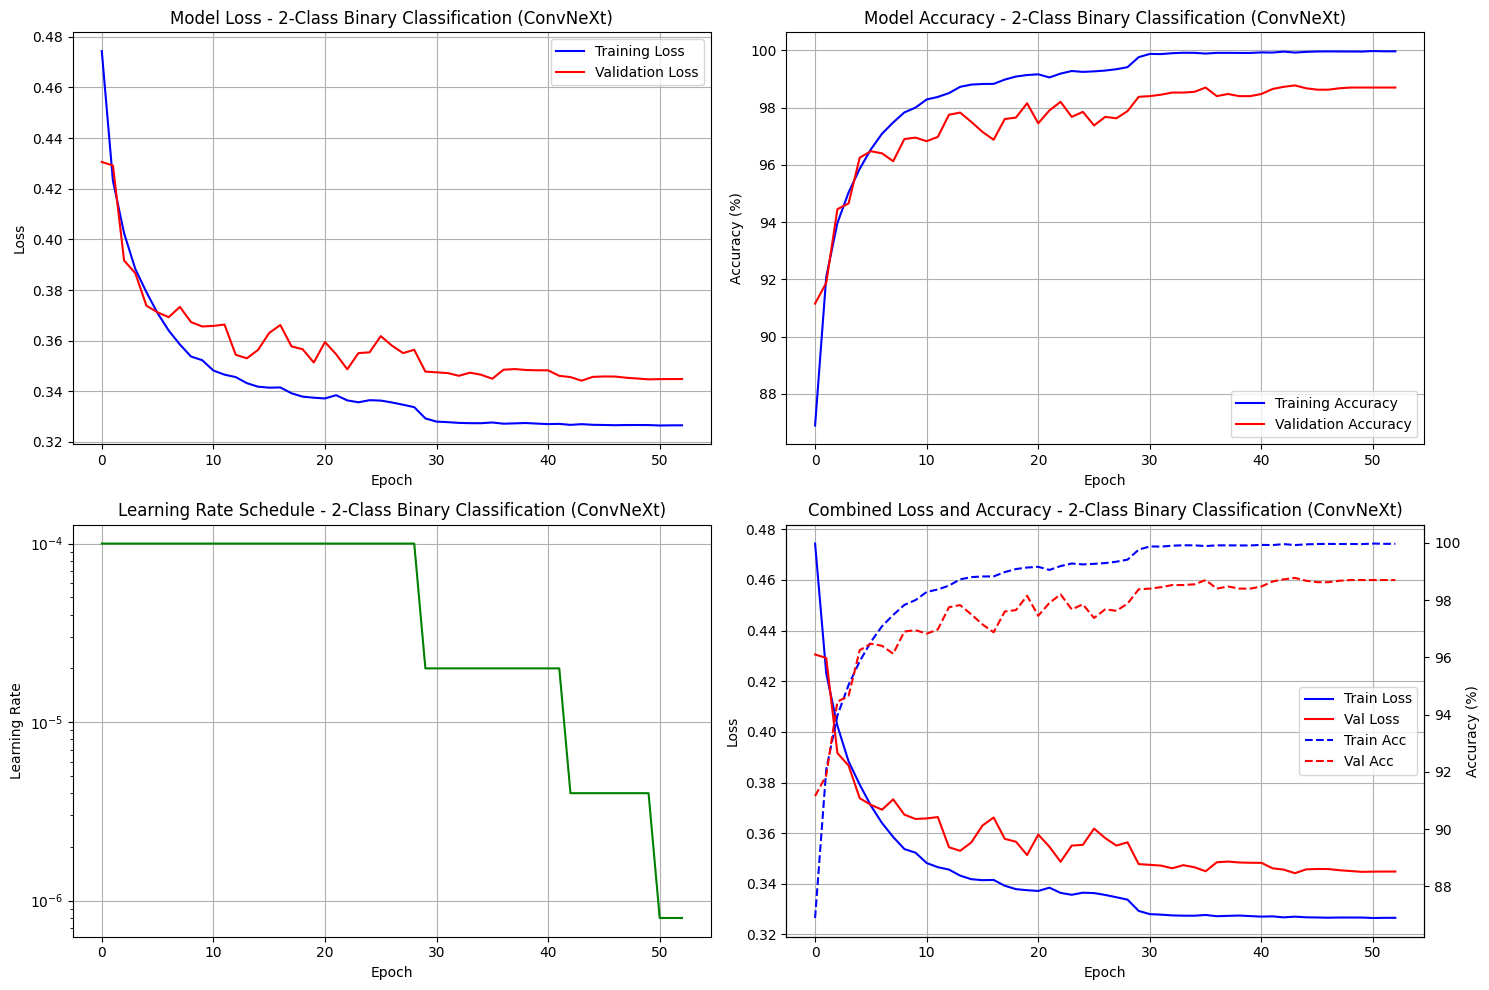

📊 Training plots saved to results\2_class_pytorch/training_history_convnext_2class_stratified.png
💾 Training history saved to results\2_class_pytorch/training_history_convnext_2class_stratified.json


In [8]:
# Plot training history and save results
def plot_training_history(history, save_path):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Model Loss - 2-Class Binary Classification (ConvNeXt)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy plot
    axes[0, 1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0, 1].set_title('Model Accuracy - 2-Class Binary Classification (ConvNeXt)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Learning rate plot
    axes[1, 0].plot(history['learning_rates'], color='green')
    axes[1, 0].set_title('Learning Rate Schedule - 2-Class Binary Classification (ConvNeXt)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)
    
    # Combined loss and accuracy
    ax1 = axes[1, 1]
    ax2 = ax1.twinx()
    
    line1 = ax1.plot(history['train_loss'], 'b-', label='Train Loss')
    line2 = ax1.plot(history['val_loss'], 'r-', label='Val Loss')
    line3 = ax2.plot(history['train_acc'], 'b--', label='Train Acc')
    line4 = ax2.plot(history['val_acc'], 'r--', label='Val Acc')
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='black')
    ax2.set_ylabel('Accuracy (%)', color='black')
    ax1.set_title('Combined Loss and Accuracy - 2-Class Binary Classification (ConvNeXt)')
    
    # Combine legends
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    ax1.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path / 'training_history_convnext_2class_stratified.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot and save training history
plot_training_history(history, RESULTS_PATH)

# Save training history as JSON
with open(RESULTS_PATH / 'training_history_convnext_2class_stratified.json', 'w') as f:
    json.dump(history, f, indent=4)

print(f"📊 Training plots saved to {RESULTS_PATH}/training_history_convnext_2class_stratified.png")
print(f"💾 Training history saved to {RESULTS_PATH}/training_history_convnext_2class_stratified.json")


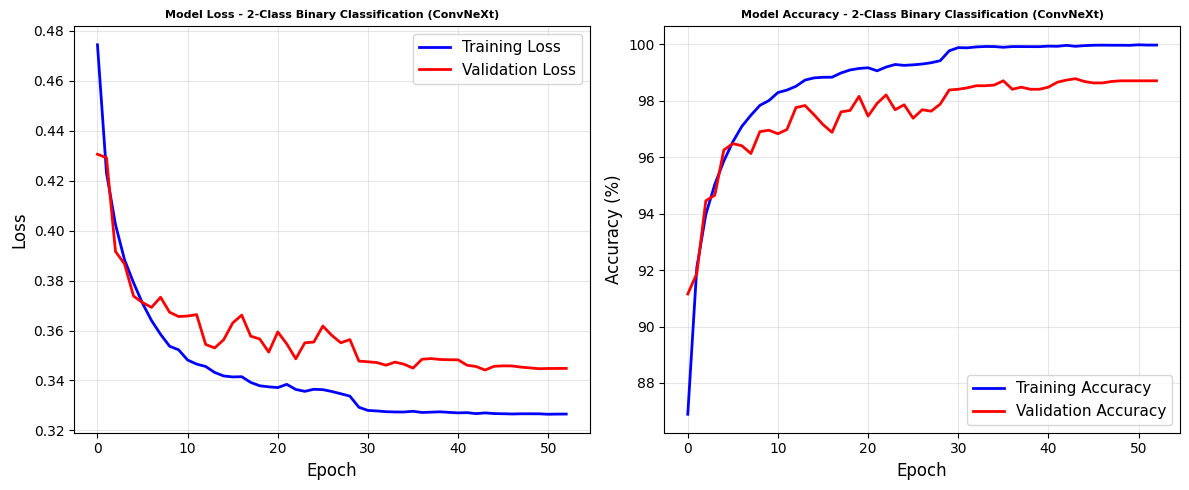

📊 Model Loss and Accuracy plots saved to results\2_class_pytorch/model_loss_accuracy_convnext_2class_stratified.png


In [16]:
# Create additional plots for Model Loss and Model Accuracy separately
def plot_loss_accuracy_separate(history, save_path):
    # Model Loss plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    plt.title('Model Loss - 2-Class Binary Classification (ConvNeXt)', fontsize=8, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Model Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red', linewidth=2)
    plt.title('Model Accuracy - 2-Class Binary Classification (ConvNeXt)', fontsize=8, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path / 'model_loss_accuracy_convnext_2class_stratified.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot separate loss and accuracy charts
plot_loss_accuracy_separate(history, RESULTS_PATH)
print(f"📊 Model Loss and Accuracy plots saved to {RESULTS_PATH}/model_loss_accuracy_convnext_2class_stratified.png")


In [10]:
# Check if best model exists, if not use current model state
model_path = MODEL_SAVE_PATH / 'best_model_convnext_2class_stratified.pth'

if model_path.exists():
    # Load best model and evaluate
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Best ConvNeXt model loaded from epoch {checkpoint['epoch']}")
    print(f"📊 Validation accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"📊 Validation loss: {checkpoint['val_loss']:.4f}")
else:
    print("⚠️ Best model checkpoint not found. Using current model state for evaluation.")
    model.eval()

# Evaluation function
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing ConvNeXt')
        
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    
    # Classification report
    class_report = classification_report(
        all_targets, all_predictions,
        target_names=class_names,
        digits=4
    )
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    return {
        'accuracy': accuracy,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'classification_report': class_report,
        'confusion_matrix': cm
    }

# Evaluate on test set
test_results = evaluate_model(model, test_loader, device, full_dataset.classes)

print(f"\n🎯 ConvNeXt Test Results:")
print(f"  Test Accuracy: {test_results['accuracy']*100:.2f}%")
print(f"\n📋 Classification Report:")
print(test_results['classification_report'])


⚠️ Best model checkpoint not found. Using current model state for evaluation.


Testing ConvNeXt: 100%|██████████| 63/63 [00:08<00:00,  7.63it/s]


🎯 ConvNeXt Test Results:
  Test Accuracy: 99.05%

📋 Classification Report:
              precision    recall  f1-score   support

     Anomaly     0.9945    0.9865    0.9905      2000
  No-Anomaly     0.9866    0.9945    0.9905      2000

    accuracy                         0.9905      4000
   macro avg     0.9905    0.9905    0.9905      4000
weighted avg     0.9905    0.9905    0.9905      4000



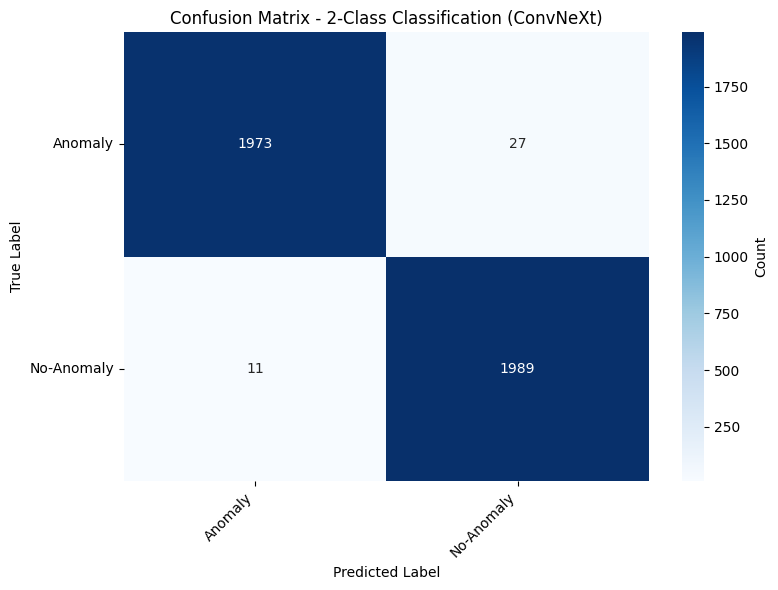

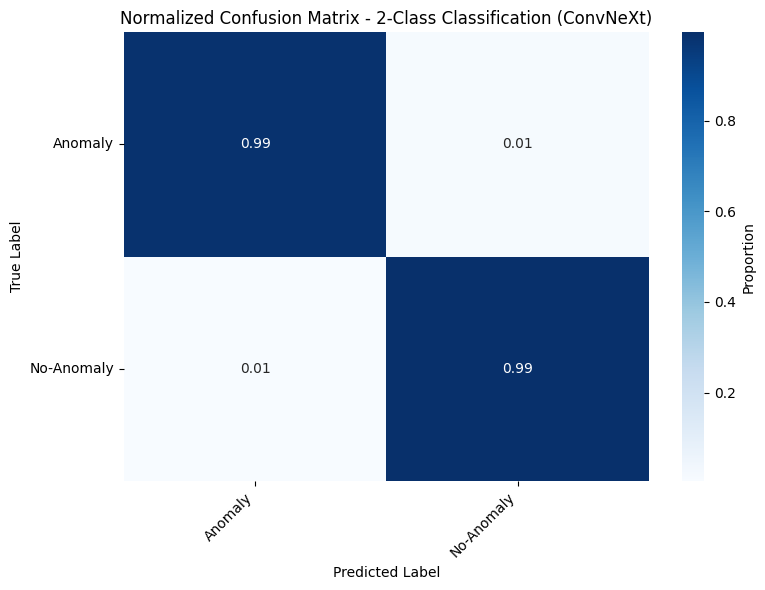

📊 Per-Class Performance:
--------------------------------------------------
Anomaly        :  98.65% (1973/2000)
No-Anomaly     :  99.45% (1989/2000)
--------------------------------------------------
Overall        :  99.05%


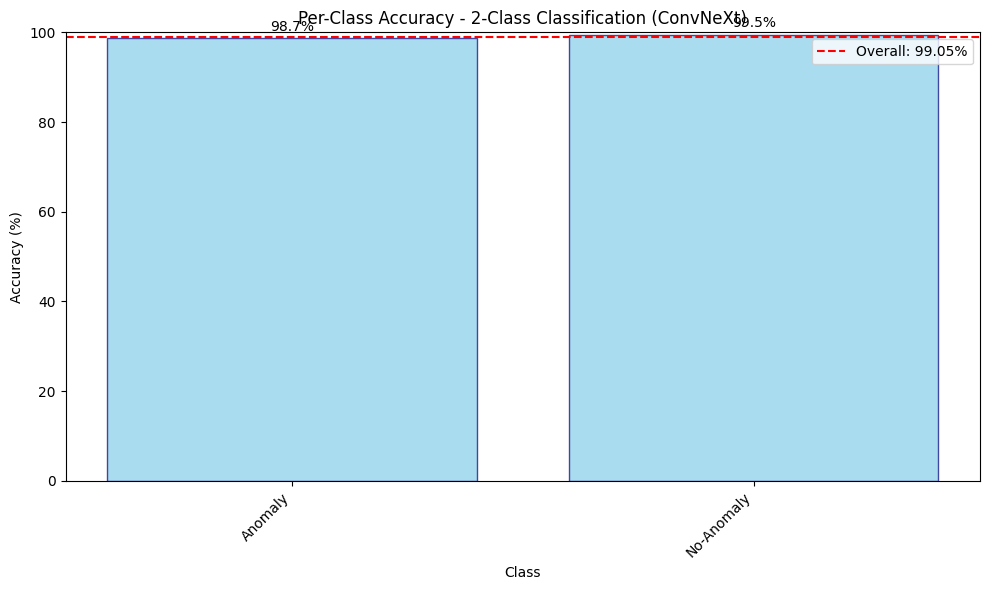

📊 Confusion matrices and analysis plots saved to results\2_class_pytorch/


In [11]:
# Plot confusion matrix and per-class analysis
def plot_confusion_matrix(cm, class_names, save_path, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix - 2-Class Classification (ConvNeXt)'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix - 2-Class Classification (ConvNeXt)'
        fmt = 'd'
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    filename = 'confusion_matrix_normalized_2class.png' if normalize else 'confusion_matrix_2class.png'
    plt.savefig(save_path / filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot both normalized and non-normalized confusion matrices
plot_confusion_matrix(test_results['confusion_matrix'], full_dataset.classes, RESULTS_PATH, normalize=False)
plot_confusion_matrix(test_results['confusion_matrix'], full_dataset.classes, RESULTS_PATH, normalize=True)

# Per-class accuracy analysis
def analyze_per_class_performance(cm, class_names):
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    print("📊 Per-Class Performance:")
    print("-" * 50)
    
    results = []
    for i, (class_name, acc) in enumerate(zip(class_names, per_class_acc)):
        total_samples = cm.sum(axis=1)[i]
        correct_samples = cm.diagonal()[i]
        
        print(f"{class_name:15s}: {acc*100:6.2f}% ({correct_samples:4d}/{total_samples:4d})")
        
        results.append({
            'class': class_name,
            'accuracy': acc,
            'correct': int(correct_samples),
            'total': int(total_samples)
        })
    
    print("-" * 50)
    print(f"{'Overall':15s}: {test_results['accuracy']*100:6.2f}%")
    
    return results

# Analyze per-class performance
per_class_results = analyze_per_class_performance(test_results['confusion_matrix'], full_dataset.classes)

# Create a bar plot for per-class accuracies
plt.figure(figsize=(10, 6))
classes = [r['class'] for r in per_class_results]
accuracies = [r['accuracy'] * 100 for r in per_class_results]

bars = plt.bar(classes, accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Per-Class Accuracy - 2-Class Classification (ConvNeXt)')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=10)

# Add overall accuracy line
plt.axhline(y=test_results['accuracy']*100, color='red', linestyle='--', 
            label=f'Overall: {test_results["accuracy"]*100:.2f}%')
plt.legend()

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'per_class_accuracy_2class.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Confusion matrices and analysis plots saved to {RESULTS_PATH}/")


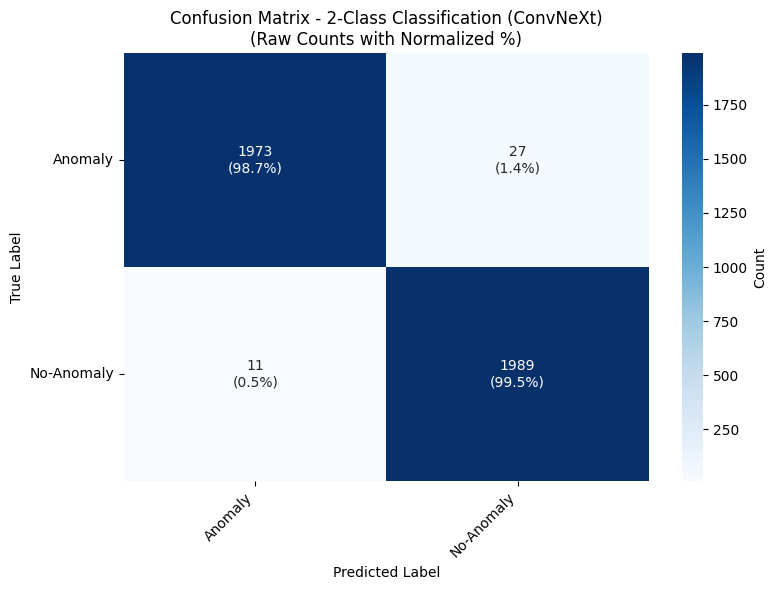

In [17]:
# Modified confusion matrix plot with both raw counts and normalized values
def plot_confusion_matrix_combined(cm, class_names, save_path):
    """
    Plot confusion matrix with both raw counts and normalized percentages in each cell
    """
    # Calculate normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    
    # Create annotations with both count and percentage
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = cm_normalized[i, j] * 100
            annotation = f'{count}\n({percentage:.1f}%)'
            row.append(annotation)
        annotations.append(row)
    
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix - 2-Class Classification (ConvNeXt)\n(Raw Counts with Normalized %)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    filename = 'confusion_matrix_combined_2class.png'
    plt.savefig(save_path / filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot the combined confusion matrix
plot_confusion_matrix_combined(test_results['confusion_matrix'], full_dataset.classes, RESULTS_PATH)


In [12]:
# Testing the Model with Custom Images

import os
from PIL import Image
import torch.nn.functional as F

def test_single_image(model, image_path, transform, device, classes):
    """
    Test a single image with the trained ConvNeXt model for 2-class solar PV anomaly detection
    
    Args:
        model: Trained ConvNeXt model
        image_path: Path to the thermal image
        transform: Image preprocessing transforms
        device: Device (CPU/GPU)
        classes: List of class names ['Anomaly', 'No-Anomaly']
    
    Returns:
        predicted_class: Predicted class name
        confidence: Prediction confidence
        probabilities: All class probabilities
    """
    # Load and preprocess the thermal image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction from ConvNeXt model
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class_idx].item()
    
    predicted_class = classes[predicted_class_idx]
    
    return predicted_class, confidence, probabilities[0]

def test_custom_images(model, image_directory, transform, device, classes):
    """
    Test multiple thermal images from a directory for solar PV anomaly detection
    
    Args:
        model: Trained ConvNeXt model
        image_directory: Directory containing thermal images
        transform: Image preprocessing transforms
        device: Device (CPU/GPU)
        classes: List of class names ['Anomaly', 'No-Anomaly']
    
    Returns:
        results: List of prediction results
    """
    if not os.path.exists(image_directory):
        print(f"Directory {image_directory} does not exist!")
        return
    
    # Get all thermal image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(image_directory) 
                   if any(f.lower().endswith(ext) for ext in image_extensions)]
    
    if not image_files:
        print(f"No thermal image files found in {image_directory}")
        return
    
    print(f"Testing {len(image_files)} thermal images from {image_directory}")
    print("-" * 60)
    
    results = []
    for image_file in image_files[:10]:  # Test first 10 images
        image_path = os.path.join(image_directory, image_file)
        try:
            predicted_class, confidence, all_probs = test_single_image(
                model, image_path, transform, device, classes
            )
            
            print(f"Image: {image_file:25s} | Predicted: {predicted_class:15s} | Confidence: {confidence:.3f}")
            
            results.append({
                'image': image_file,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'probabilities': all_probs.cpu().numpy()
            })
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
    
    return results

# Example usage - Test ConvNeXt model with validation samples
print("🧪 Testing ConvNeXt Model for 2-Class Solar PV Anomaly Detection")
print("=" * 60)

# Test with some validation images (uses StratifiedShuffleSplit split data)
val_loader_single = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True
)

# Test a few random validation samples from the stratified split
print("\n📋 Testing Random Validation Samples (from StratifiedShuffleSplit):")
print("-" * 60)

model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader_single):
        if i >= 5:  # Test only 5 samples
            break
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        confidence = probabilities[0][predicted].item()
        
        true_class = full_dataset.classes[labels.item()]
        pred_class = full_dataset.classes[predicted.item()]
        
        status = "✅" if predicted.item() == labels.item() else "❌"
        
        print(f"Sample {i+1}: True: {true_class:15s} | Pred: {pred_class:15s} | "
              f"Confidence: {confidence:.3f} | {status}")

# Instructions for testing custom thermal images
print("\n" + "=" * 60)
print("📁 To test your own thermal images for solar PV anomaly detection:")
print("1. Place your thermal images in a folder")
print("2. Use the test_custom_images() function:")
print("   results = test_custom_images(model, 'path/to/your/thermal/images/', transform, device, full_dataset.classes)")
print("\n3. Or test a single thermal image:")
print("   pred_class, confidence, probs = test_single_image(model, 'thermal_image.jpg', transform, device, full_dataset.classes)")

# Example of how to visualize predictions for thermal images
def visualize_prediction(image_path, model, transform, device, classes, top_k=2):
    """
    Visualize ConvNeXt prediction results for thermal solar PV images
    
    Args:
        image_path: Path to thermal image
        model: Trained ConvNeXt model
        transform: Image preprocessing transforms
        device: Device (CPU/GPU)
        classes: List of class names ['Anomaly', 'No-Anomaly']
        top_k: Number of top predictions to show (default 2 for binary classification)
    
    Returns:
        top_class: Top predicted class
        top_prob: Top prediction probability
    """
    # Load and preprocess thermal image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction from ConvNeXt
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Show original thermal image
    ax1.imshow(image)
    ax1.set_title('Thermal Solar PV Image')
    ax1.axis('off')
    
    # Show top predictions for 2-class classification
    top_classes = [classes[idx] for idx in top_indices[0]]
    top_probs_list = top_probs[0].cpu().numpy()
    
    colors = ['lightcoral' if cls == 'Anomaly' else 'lightgreen' for cls in top_classes]
    bars = ax2.barh(range(top_k), top_probs_list, color=colors)
    ax2.set_yticks(range(top_k))
    ax2.set_yticklabels(top_classes)
    ax2.set_xlabel('Probability')
    ax2.set_title(f'ConvNeXt Predictions - 2-Class Solar PV')
    ax2.set_xlim(0, 1)
    
    # Add probability values on bars
    for i, (bar, prob) in enumerate(zip(bars, top_probs_list)):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{prob:.3f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return top_classes[0], top_probs_list[0]

print("\n🎯 Use visualize_prediction() to see detailed ConvNeXt prediction results with visualization")
print("Example: visualize_prediction('path/to/thermal_image.jpg', model, transform, device, full_dataset.classes)")
print("\n📊 Classes: Anomaly (solar PV defects) vs No-Anomaly (normal panels)")


🧪 Testing ConvNeXt Model for 2-Class Solar PV Anomaly Detection

📋 Testing Random Validation Samples (from StratifiedShuffleSplit):
------------------------------------------------------------
Sample 1: True: Anomaly         | Pred: Anomaly         | Confidence: 0.900 | ✅
Sample 2: True: No-Anomaly      | Pred: No-Anomaly      | Confidence: 0.901 | ✅
Sample 3: True: No-Anomaly      | Pred: No-Anomaly      | Confidence: 0.898 | ✅
Sample 4: True: Anomaly         | Pred: Anomaly         | Confidence: 0.900 | ✅
Sample 5: True: Anomaly         | Pred: Anomaly         | Confidence: 0.899 | ✅

📁 To test your own thermal images for solar PV anomaly detection:
1. Place your thermal images in a folder
2. Use the test_custom_images() function:
   results = test_custom_images(model, 'path/to/your/thermal/images/', transform, device, full_dataset.classes)

3. Or test a single thermal image:
   pred_class, confidence, probs = test_single_image(model, 'thermal_image.jpg', transform, device, full_data

✅ Found custom thermal solar PV images directory: C:\Users\Zeshan\Desktop\InfraredSolarModules
📸 Found 20000 thermal solar PV images to test

📊 Class distribution in custom thermal solar PV dataset:
   images: 20000 thermal images

🔍 Testing stratified random samples from your thermal solar PV images:
   ConvNeXt 2-Class Classification: Anomaly vs No-Anomaly
------------------------------------------------------------
ℹ️ Only one class found, using random sampling

📷 Thermal Solar PV Sample 1: 5704.jpg
   📁 From class: images


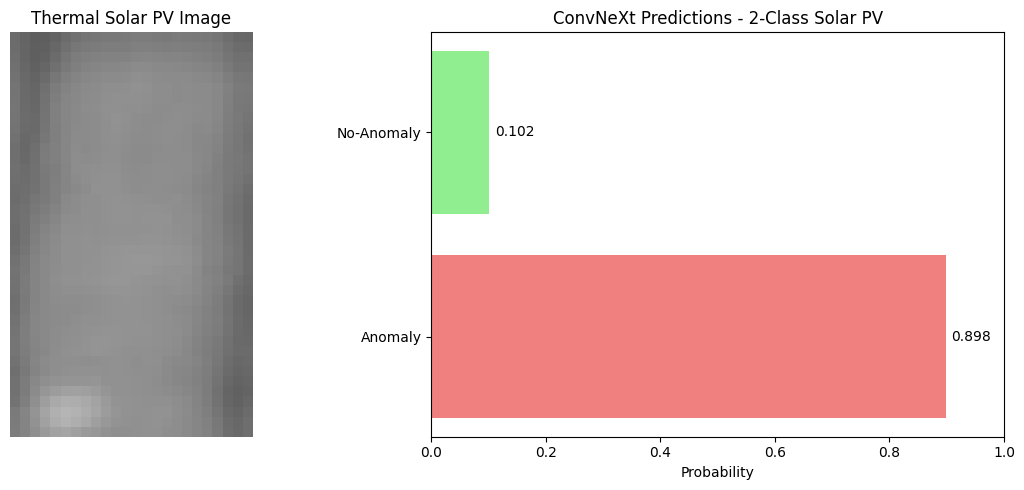

🎯 ConvNeXt Prediction: Anomaly (Confidence: 0.898)
   ⚠️ Solar PV panel defect detected - requires inspection

📷 Thermal Solar PV Sample 2: 11890.jpg
   📁 From class: images


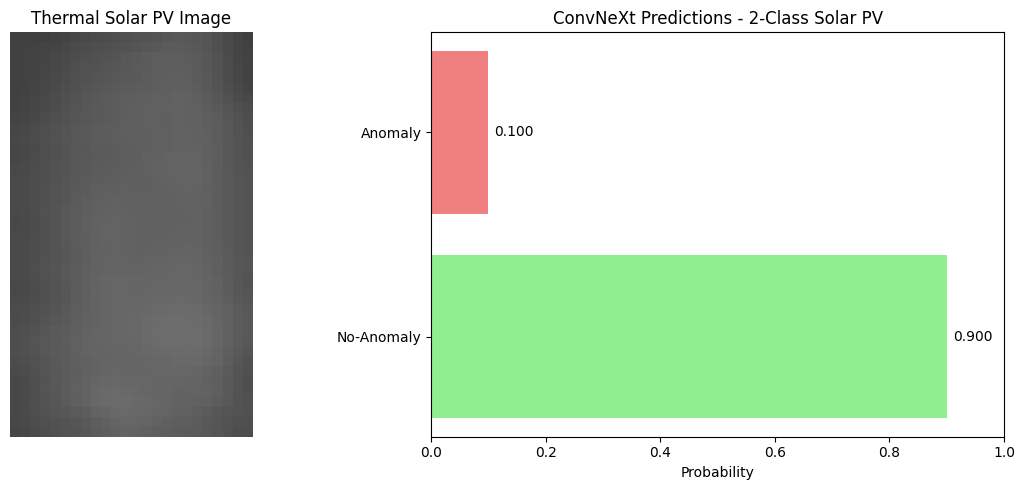

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.900)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 3: 18771.jpg
   📁 From class: images


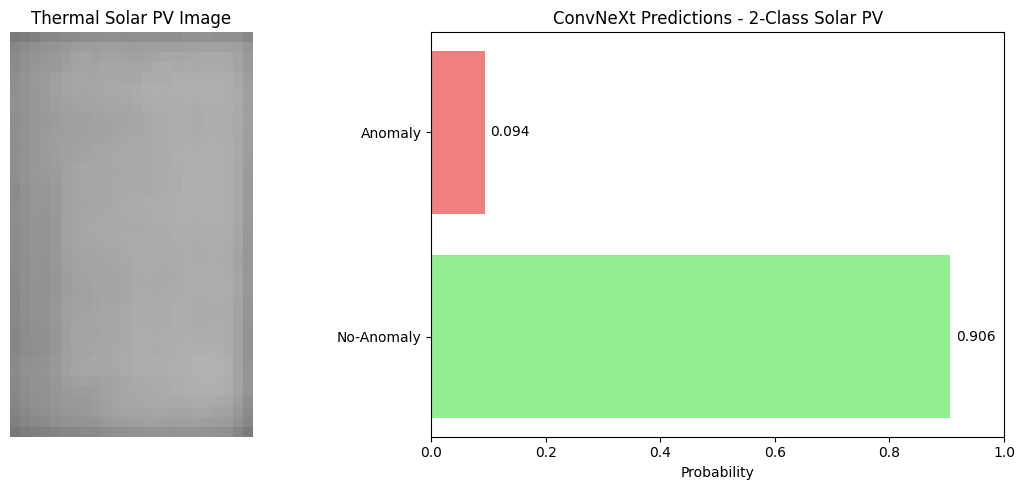

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.906)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 4: 12400.jpg
   📁 From class: images


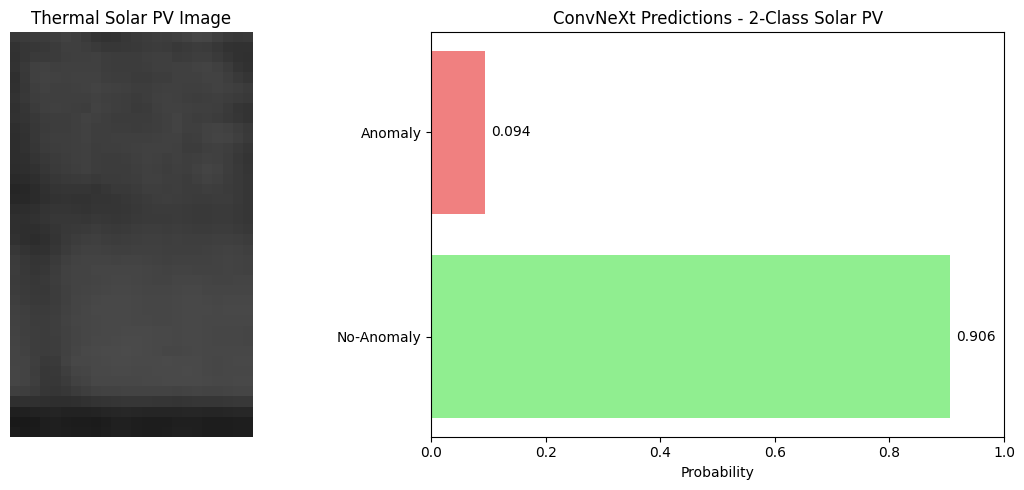

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.906)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 5: 12316.jpg
   📁 From class: images


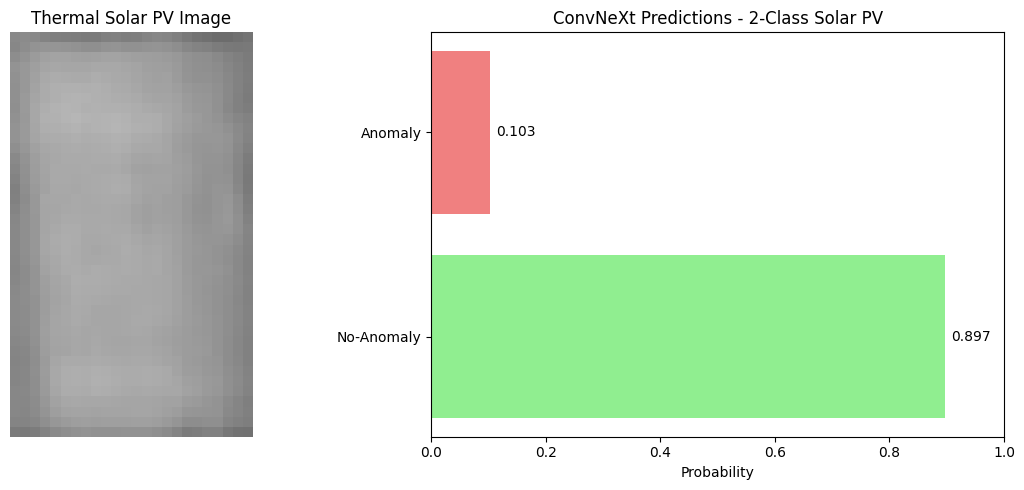

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.897)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 6: 19343.jpg
   📁 From class: images


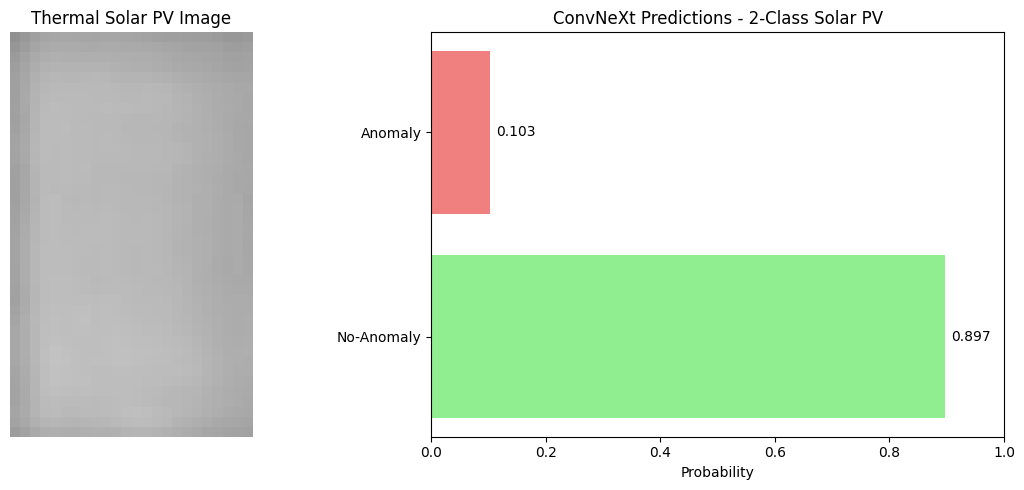

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.897)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 7: 12995.jpg
   📁 From class: images


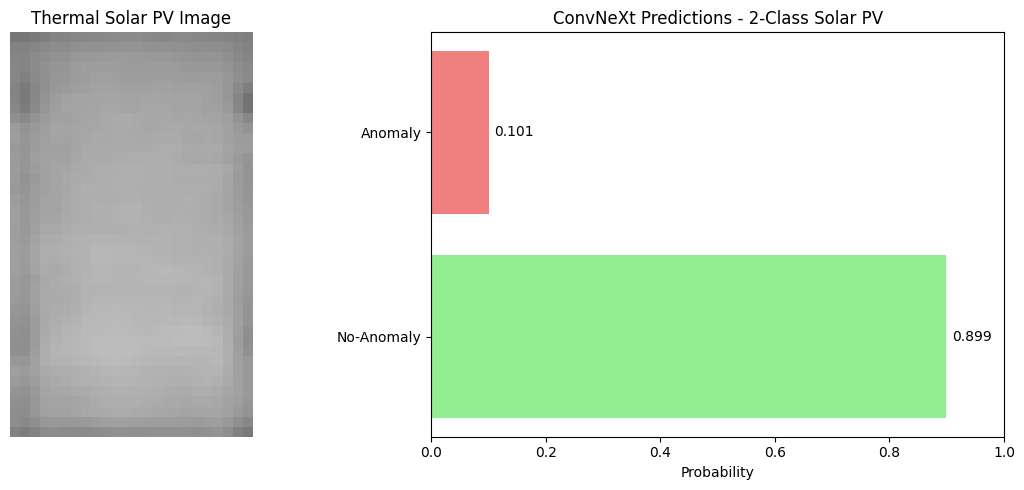

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.899)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 8: 11033.jpg
   📁 From class: images


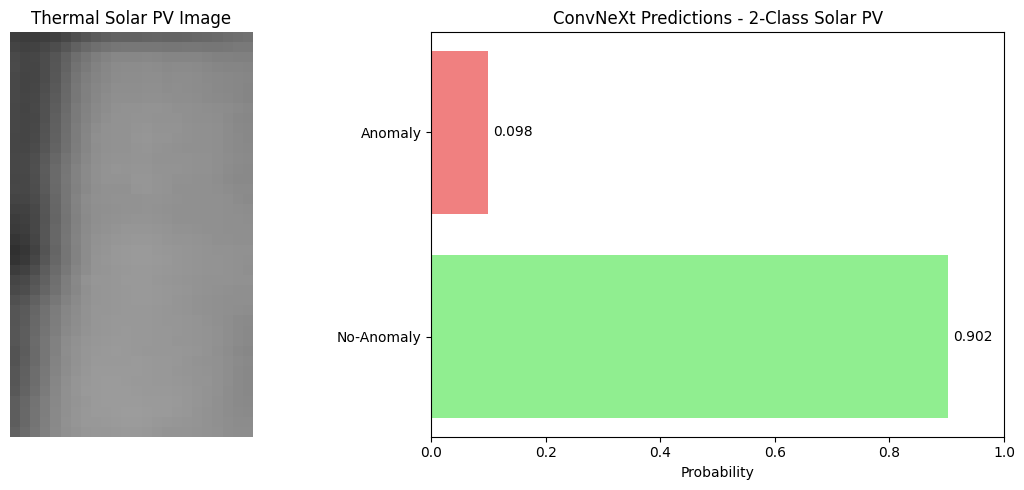

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.902)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 9: 13445.jpg
   📁 From class: images


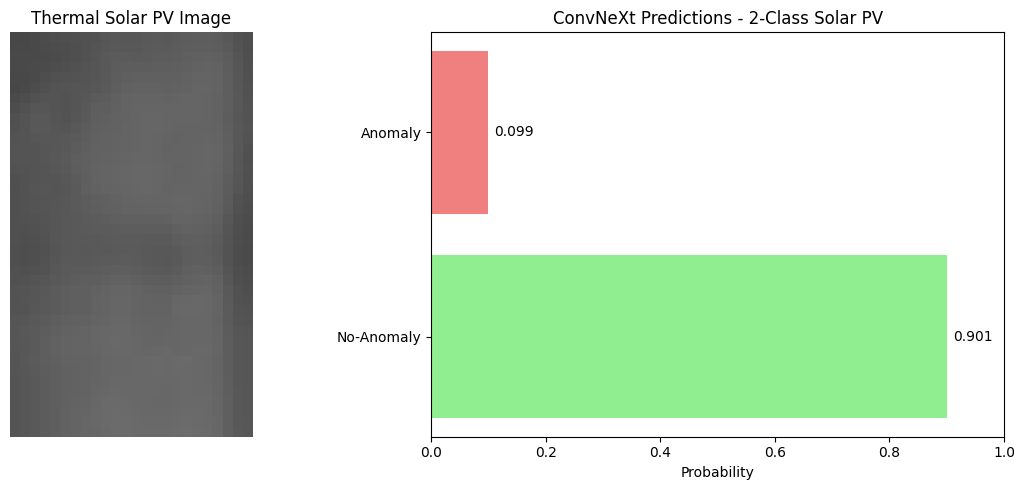

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.901)
   ✅ Normal solar PV panel - no anomalies detected

📷 Thermal Solar PV Sample 10: 18008.jpg
   📁 From class: images


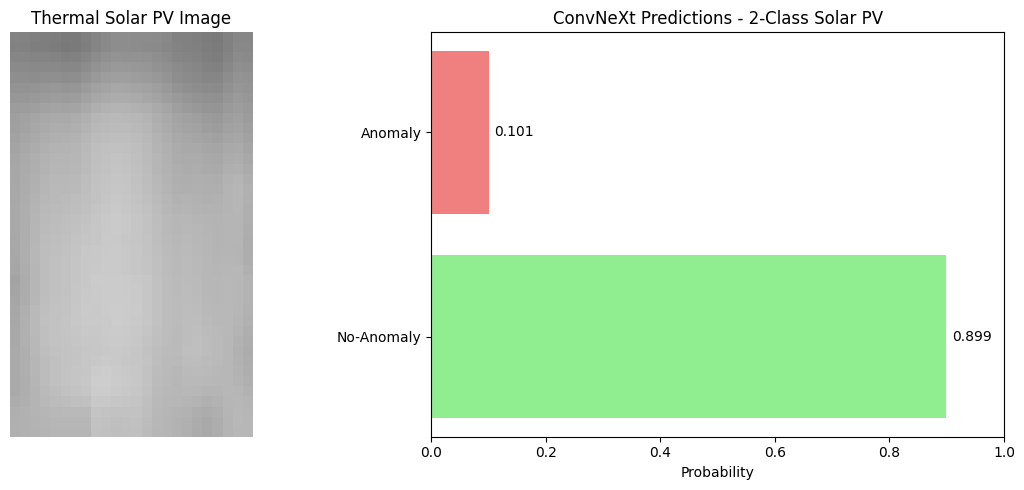

🎯 ConvNeXt Prediction: No-Anomaly (Confidence: 0.899)
   ✅ Normal solar PV panel - no anomalies detected

✅ ConvNeXt 2-Class Solar PV Anomaly Detection - Stratified sampling completed!

💡 To test a specific thermal solar PV image, use:
visualize_prediction('full_path_to_thermal_image.jpg', model, transform, device, full_dataset.classes)

🚀 ConvNeXt 2-Class Solar PV Anomaly Detection Functions:
   • test_single_image('thermal_image.jpg') - Test specific thermal solar PV image
   • test_stratified_samples(num_samples=5) - Test stratified samples across classes

📊 Classes: Anomaly (solar PV defects) vs No-Anomaly (normal panels)


In [13]:
# Test the model with your own images
import os
import random
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit

# Define the transform for custom images (same as used during training)
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to your custom thermal solar PV images
custom_images_path = r"C:\Users\Zeshan\Desktop\InfraredSolarModules"

# Check if the path exists
if os.path.exists(custom_images_path):
    print(f"✅ Found custom thermal solar PV images directory: {custom_images_path}")
    
    # Get list of thermal image files (common formats) - improved search
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    image_files = []
    image_labels = []  # Store labels for stratified sampling
    
    # Search in all subdirectories for thermal solar PV images
    for root, dirs, files in os.walk(custom_images_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_path = Path(root) / file
                image_files.append(image_path)
                # Extract label from folder structure (parent folder name)
                label = Path(root).name
                image_labels.append(label)
    
    print(f"📸 Found {len(image_files)} thermal solar PV images to test")
    
    if len(image_files) > 0:
        # Show class distribution for 2-class solar PV anomaly detection
        from collections import Counter
        label_counts = Counter(image_labels)
        print(f"\n📊 Class distribution in custom thermal solar PV dataset:")
        for label, count in label_counts.items():
            print(f"   {label}: {count} thermal images")
        
        print("\n🔍 Testing stratified random samples from your thermal solar PV images:")
        print("   ConvNeXt 2-Class Classification: Anomaly vs No-Anomaly")
        print("-" * 60)
        
        # Use StratifiedShuffleSplit for balanced sampling across classes
        num_samples = min(10, len(image_files))  # Take up to 10 stratified samples
        
        # Only proceed if we have at least 2 classes for stratification
        if len(label_counts) > 1:
            # Create stratified split
            sss = StratifiedShuffleSplit(n_splits=1, test_size=num_samples, random_state=42)
            
            try:
                # Get stratified sample indices
                _, sample_indices = next(sss.split(image_files, image_labels))
                stratified_sample = [image_files[i] for i in sample_indices]
                
                print(f"✅ Using StratifiedShuffleSplit for balanced sampling across {len(label_counts)} classes")
                
            except ValueError as e:
                # Fallback to random sampling if stratification fails
                print(f"⚠️ Stratification failed ({str(e)}), using random sampling instead")
                stratified_sample = random.sample(image_files, num_samples)
        else:
            # Single class - use random sampling
            print(f"ℹ️ Only one class found, using random sampling")
            stratified_sample = random.sample(image_files, num_samples)
        
        # Test each thermal solar PV sample with ConvNeXt 2-class model
        for i, img_path in enumerate(stratified_sample):
            print(f"\n📷 Thermal Solar PV Sample {i+1}: {img_path.name}")
            print(f"   📁 From class: {Path(img_path).parent.name}")
            try:
                predicted_class, confidence = visualize_prediction(
                    str(img_path), 
                    model, 
                    transform, 
                    device, 
                    full_dataset.classes,
                    top_k=2  # Only 2 classes for binary classification
                )
                print(f"🎯 ConvNeXt Prediction: {predicted_class} (Confidence: {confidence:.3f})")
                
                # Add interpretation for solar PV context
                if predicted_class == 'Anomaly':
                    print(f"   ⚠️ Solar PV panel defect detected - requires inspection")
                else:
                    print(f"   ✅ Normal solar PV panel - no anomalies detected")
                
            except Exception as e:
                print(f"❌ Error processing thermal image {img_path.name}: {str(e)}")
                continue
                
        print("\n" + "="*70)
        print("✅ ConvNeXt 2-Class Solar PV Anomaly Detection - Stratified sampling completed!")
        
        # Option to test a specific thermal image
        print("\n💡 To test a specific thermal solar PV image, use:")
        print("visualize_prediction('full_path_to_thermal_image.jpg', model, transform, device, full_dataset.classes)")
        
    else:
        print("❌ No thermal image files found in the directory")
        print("   Supported formats: .jpg, .jpeg, .png, .bmp, .tiff, .tif")
        print("   Make sure thermal solar PV images are directly in the folder or its subfolders")
        
        # List what's actually in the directory
        print(f"\n📁 Contents of {custom_images_path}:")
        try:
            items = list(os.listdir(custom_images_path))
            if items:
                for item in items[:10]:  # Show first 10 items
                    item_path = os.path.join(custom_images_path, item)
                    if os.path.isdir(item_path):
                        print(f"   📁 {item}/")
                    else:
                        print(f"   📄 {item}")
                if len(items) > 10:
                    print(f"   ... and {len(items) - 10} more items")
            else:
                print("   (Directory is empty)")
        except PermissionError:
            print("   (Permission denied to list directory contents)")
        
else:
    print(f"❌ Directory not found: {custom_images_path}")
    print("   Please check the path and try again")

# Function to test stratified random samples for 2-class solar PV anomaly detection
def test_stratified_samples(num_samples=5):
    """
    Test stratified random samples from the custom thermal solar PV directory using StratifiedShuffleSplit
    ConvNeXt 2-Class Classification: Anomaly vs No-Anomaly
    """
    if not os.path.exists(custom_images_path):
        print(f"❌ Directory not found: {custom_images_path}")
        return
    
    # Get all thermal image files with labels
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    image_files = []
    image_labels = []
    
    for root, dirs, files in os.walk(custom_images_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_path = Path(root) / file
                image_files.append(image_path)
                # Extract label from folder structure
                label = Path(root).name
                image_labels.append(label)
    
    if len(image_files) == 0:
        print("❌ No thermal solar PV images found in the directory")
        return
    
    # Show class distribution for solar PV anomaly detection
    from collections import Counter
    label_counts = Counter(image_labels)
    print(f"📊 Found {len(label_counts)} classes in thermal solar PV dataset:")
    for label, count in label_counts.items():
        print(f"   {label}: {count} thermal images")
    
    # Use StratifiedShuffleSplit for balanced sampling
    num_samples = min(num_samples, len(image_files))
    
    if len(label_counts) > 1:
        try:
            sss = StratifiedShuffleSplit(n_splits=1, test_size=num_samples, random_state=42)
            _, sample_indices = next(sss.split(image_files, image_labels))
            stratified_sample = [image_files[i] for i in sample_indices]
            print(f"\n🎯 ConvNeXt 2-Class Solar PV: Using StratifiedShuffleSplit for {num_samples} balanced samples:")
        except ValueError as e:
            print(f"⚠️ Stratification failed ({str(e)}), using random sampling")
            stratified_sample = random.sample(image_files, num_samples)
    else:
        print(f"\nℹ️ Single class detected, using random sampling for {num_samples} samples:")
        stratified_sample = random.sample(image_files, num_samples)
    
    print("-" * 50)
    
    for i, img_path in enumerate(stratified_sample):
        print(f"\n📷 Thermal Solar PV Sample {i+1}: {img_path.name}")
        print(f"   📁 Class: {Path(img_path).parent.name}")
        try:
            predicted_class, confidence = visualize_prediction(
                str(img_path), 
                model, 
                transform, 
                device, 
                full_dataset.classes,
                top_k=2  # Binary classification
            )
            print(f"🎯 ConvNeXt Prediction: {predicted_class} (Confidence: {confidence:.3f})")
            
            # Solar PV specific interpretation
            if predicted_class == 'Anomaly':
                print(f"   ⚠️ Solar PV defect detected - panel requires maintenance")
            else:
                print(f"   ✅ Normal solar PV operation - no anomalies found")
                
        except Exception as e:
            print(f"❌ Error processing thermal image {img_path.name}: {str(e)}")

# Quick test function for individual thermal solar PV images
def test_single_image(image_name):
    """
    Quick function to test a single thermal solar PV image by name from your custom directory
    ConvNeXt 2-Class Solar PV Anomaly Detection
    """
    # Search for the thermal image in the directory and subdirectories
    for root, dirs, files in os.walk(custom_images_path):
        if image_name in files:
            image_path = os.path.join(root, image_name)
            print(f"🔍 Testing thermal solar PV image: {image_name}")
            predicted_class, confidence = visualize_prediction(image_path, model, transform, device, full_dataset.classes)
            
            # Solar PV specific output
            if predicted_class and confidence:
                print(f"🎯 ConvNeXt 2-Class Result: {predicted_class} (Confidence: {confidence:.3f})")
                if predicted_class == 'Anomaly':
                    print(f"   ⚠️ Solar PV anomaly detected - panel inspection recommended")
                else:
                    print(f"   ✅ Normal solar PV panel - no defects found")
            
            return predicted_class, confidence
    
    print(f"❌ Thermal image not found: {image_name}")
    print("   Available thermal solar PV images:")
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    found_images = []
    for root, dirs, files in os.walk(custom_images_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                found_images.append(file)
    
    if found_images:
        # Show random sample of available thermal images
        sample_size = min(5, len(found_images))
        random_sample = random.sample(found_images, sample_size)
        for img in random_sample:
            print(f"   📷 {img}")
        if len(found_images) > 5:
            print(f"   ... and {len(found_images) - 5} more thermal images")
    else:
        print("   (No thermal images found)")
    
    return None, None

print("\n🚀 ConvNeXt 2-Class Solar PV Anomaly Detection Functions:")
print("   • test_single_image('thermal_image.jpg') - Test specific thermal solar PV image")
print("   • test_stratified_samples(num_samples=5) - Test stratified samples across classes")
print("\n📊 Classes: Anomaly (solar PV defects) vs No-Anomaly (normal panels)")


🔬 Generating t-SNE visualization for feature analysis...
📊 Creating stratified subset for t-SNE analysis...
   Selected 600 samples for t-SNE analysis
🧠 Extracting features from ConvNeXt backbone...
   Processed 32/600 samples...
   Feature shape: (600, 768)
   Labels shape: (600,)
🔄 Computing t-SNE embedding (this may take a few minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 1.927s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.935019
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.323082
[t-SNE] KL divergence after 1000 iterations: 0.820340
✅ t-SNE computation completed!
🎨 Creating t-SNE visualizations...


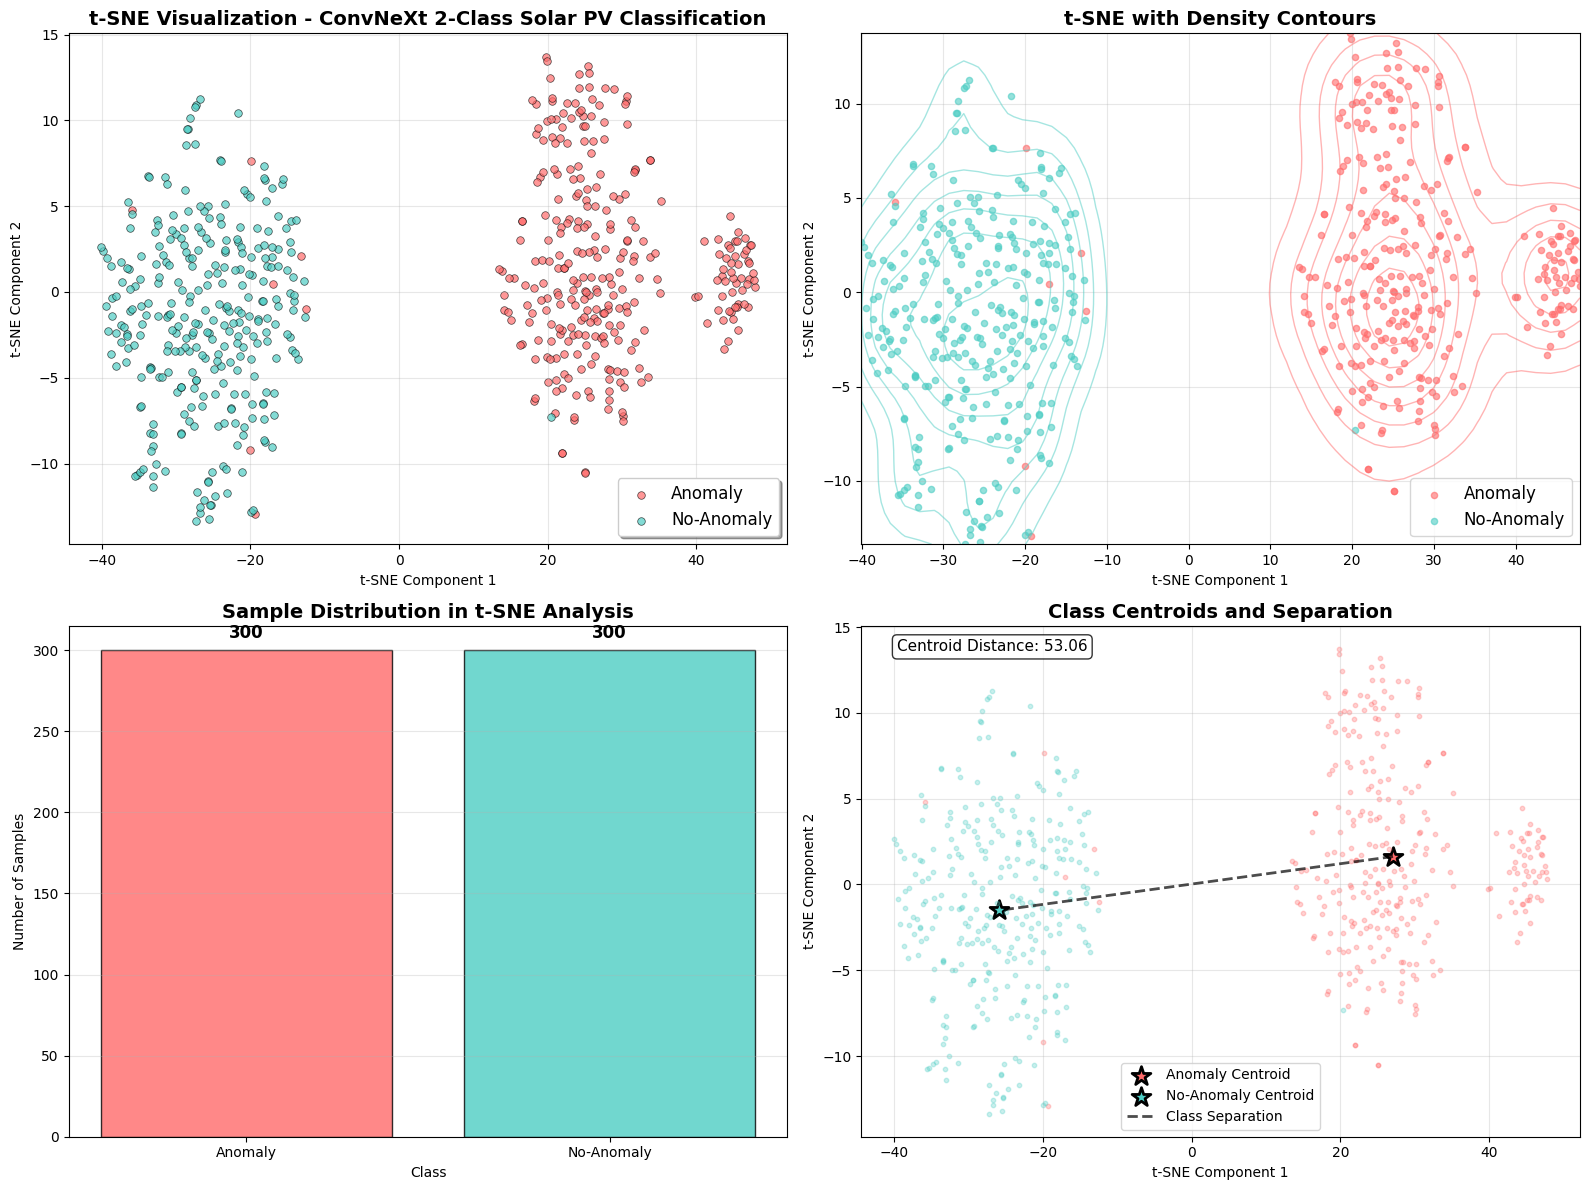

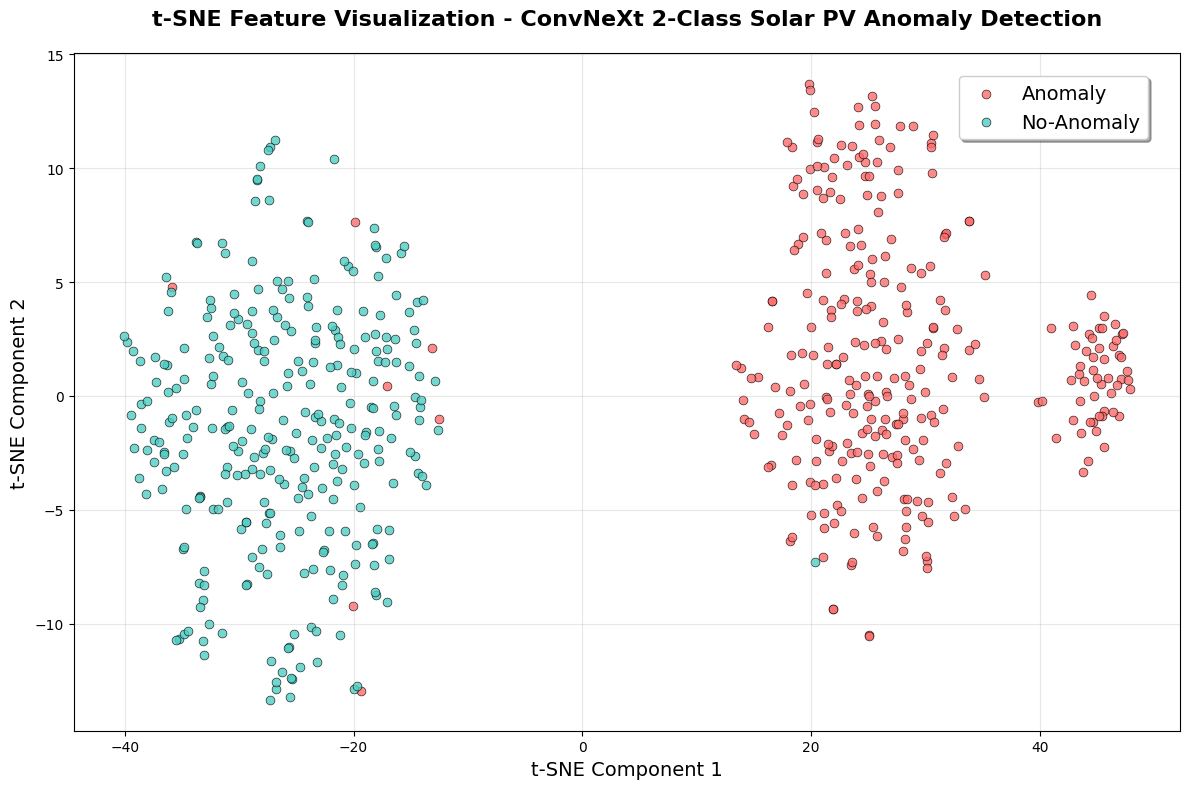


📊 t-SNE Cluster Analysis for 2-Class Solar PV Detection:
------------------------------------------------------------
Average Silhouette Score: 0.753
(Higher is better, range: -1 to 1)
   ✅ Excellent class separation

📏 Class Separation Analysis:
Anomaly     : Center=(  27.10,    1.63), Spread=  8.34
No-Anomaly  : Center=( -25.86,   -1.51), Spread=  6.26

🔍 Binary Classification Metrics:
Inter-class distance: 53.06
Average intra-class spread: 7.30
Separation ratio: 7.27
   ✅ Excellent separability - classes are well-distinguished

🎯 Solar PV Anomaly Detection Insights:
Minimum distance between classes: 0.24
This indicates the difficulty of distinguishing edge cases

Boundary Analysis:
Anomaly samples near decision boundary: 11/300 (3.7%)
No-Anomaly samples near decision boundary: 17/300 (5.7%)

💾 Saving t-SNE results...
📊 t-SNE visualizations saved to results\2_class_pytorch/
💾 t-SNE data saved to results\2_class_pytorch/tsne_results_convnext_2class.json
✅ t-SNE analysis for 2-class s

In [14]:
# t-SNE Visualization for ConvNeXt 2-Class Classification
print("🔬 Generating t-SNE visualization for feature analysis...")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import seaborn as sns
from collections import defaultdict
import random

def extract_features_and_labels(model, data_loader, device, max_samples=2000):
    """
    Extract features from the model's backbone (before final classification layer)
    """
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        sample_count = 0
        for batch_idx, (data, target) in enumerate(data_loader):
            if sample_count >= max_samples:
                break
                
            data = data.to(device)
            
            # Extract features from backbone (before classification head)
            # For ConvNeXt, we get features after global average pooling
            backbone_features = model.backbone(data)
            
            # Global average pooling if not already done
            if len(backbone_features.shape) > 2:
                backbone_features = torch.mean(backbone_features, dim=[2, 3])
            
            features.append(backbone_features.cpu().numpy())
            labels.extend(target.numpy())
            
            sample_count += len(data)
            
            if batch_idx % 50 == 0:
                print(f"   Processed {sample_count}/{max_samples} samples...")
    
    features = np.vstack(features)
    labels = np.array(labels)
    
    return features, labels

def create_stratified_subset(dataset, samples_per_class=300, random_state=42):
    """
    Create a stratified subset with equal samples per class for t-SNE
    """
    np.random.seed(random_state)
    random.seed(random_state)
    
    # Group indices by class
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    # Sample from each class
    selected_indices = []
    for class_label, indices in class_indices.items():
        if len(indices) >= samples_per_class:
            selected = np.random.choice(indices, samples_per_class, replace=False)
        else:
            selected = indices  # Use all available if less than desired
        selected_indices.extend(selected)
    
    return Subset(dataset, selected_indices)

# Create stratified subset for t-SNE (to manage computation time and memory)
print("📊 Creating stratified subset for t-SNE analysis...")
tsne_dataset = create_stratified_subset(test_dataset, samples_per_class=300)

tsne_loader = DataLoader(
    tsne_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"   Selected {len(tsne_dataset)} samples for t-SNE analysis")

# Extract features
print("🧠 Extracting features from ConvNeXt backbone...")
features, labels = extract_features_and_labels(model, tsne_loader, device, max_samples=len(tsne_dataset))

print(f"   Feature shape: {features.shape}")
print(f"   Labels shape: {labels.shape}")

# Perform t-SNE
print("🔄 Computing t-SNE embedding (this may take a few minutes)...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    random_state=42,
    verbose=1
)

tsne_features = tsne.fit_transform(features)

print("✅ t-SNE computation completed!")

# Create comprehensive t-SNE visualization for 2-class problem
def plot_tsne_visualization_2class(tsne_features, labels, class_names, save_path):
    """
    Create t-SNE visualizations specifically for 2-class solar PV anomaly detection
    """
    # Set up the plotting style
    plt.style.use('default')
    
    # Define colors for 2 classes
    colors = ['#FF6B6B', '#4ECDC4']  # Red for Anomaly, Teal for No-Anomaly
    
    # Create main visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Main t-SNE scatter plot
    ax1 = axes[0, 0]
    for i, class_name in enumerate(class_names):
        mask = labels == i
        if np.any(mask):
            ax1.scatter(tsne_features[mask, 0], tsne_features[mask, 1], 
                       c=colors[i], label=class_name, alpha=0.7, s=30, edgecolors='black', linewidth=0.5)
    
    ax1.set_title('t-SNE Visualization - ConvNeXt 2-Class Solar PV Classification', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Density contour plot
    ax2 = axes[0, 1]
    for i, class_name in enumerate(class_names):
        mask = labels == i
        if np.any(mask):
            ax2.scatter(tsne_features[mask, 0], tsne_features[mask, 1], 
                       c=colors[i], label=class_name, alpha=0.6, s=20)
    
    # Add density contours
    from scipy.stats import gaussian_kde
    for i, class_name in enumerate(class_names):
        mask = labels == i
        if np.any(mask) and np.sum(mask) > 10:  # Need enough points for KDE
            points = tsne_features[mask]
            try:
                kde = gaussian_kde(points.T)
                x_min, x_max = tsne_features[:, 0].min(), tsne_features[:, 0].max()
                y_min, y_max = tsne_features[:, 1].min(), tsne_features[:, 1].max()
                xx, yy = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
                positions = np.vstack([xx.ravel(), yy.ravel()])
                density = kde(positions).reshape(xx.shape)
                ax2.contour(xx, yy, density, colors=colors[i], alpha=0.5, linewidths=1)
            except:
                pass  # Skip if KDE fails
    
    ax2.set_title('t-SNE with Density Contours', fontsize=14, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Class distribution
    ax3 = axes[1, 0]
    unique_labels, counts = np.unique(labels, return_counts=True)
    class_names_subset = [class_names[i] for i in unique_labels]
    
    bars = ax3.bar(class_names_subset, counts, color=[colors[i] for i in unique_labels], 
                   alpha=0.8, edgecolor='black', linewidth=1)
    ax3.set_title('Sample Distribution in t-SNE Analysis', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Class')
    ax3.set_ylabel('Number of Samples')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Feature space analysis
    ax4 = axes[1, 1]
    
    # Calculate class centroids and separation
    centroids = []
    for i in range(len(class_names)):
        mask = labels == i
        if np.any(mask):
            centroid = np.mean(tsne_features[mask], axis=0)
            centroids.append(centroid)
            ax4.scatter(centroid[0], centroid[1], c=colors[i], s=200, 
                       marker='*', edgecolors='black', linewidth=2, 
                       label=f'{class_names[i]} Centroid')
    
    # Draw line between centroids if we have 2 classes
    if len(centroids) == 2:
        ax4.plot([centroids[0][0], centroids[1][0]], 
                [centroids[0][1], centroids[1][1]], 
                'k--', alpha=0.7, linewidth=2, label='Class Separation')
        
        # Calculate and display separation distance
        separation_dist = np.linalg.norm(np.array(centroids[0]) - np.array(centroids[1]))
        ax4.text(0.05, 0.95, f'Centroid Distance: {separation_dist:.2f}', 
                transform=ax4.transAxes, fontsize=11, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Add all points with transparency
    for i, class_name in enumerate(class_names):
        mask = labels == i
        if np.any(mask):
            ax4.scatter(tsne_features[mask, 0], tsne_features[mask, 1], 
                       c=colors[i], alpha=0.3, s=10)
    
    ax4.set_title('Class Centroids and Separation', fontsize=14, fontweight='bold')
    ax4.set_xlabel('t-SNE Component 1')
    ax4.set_ylabel('t-SNE Component 2')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path / 'tsne_analysis_convnext_2class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a separate high-quality plot for publication
    plt.figure(figsize=(12, 8))
    
    for i, class_name in enumerate(class_names):
        mask = labels == i
        if np.any(mask):
            plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], 
                       c=colors[i], label=class_name, alpha=0.8, s=40, 
                       edgecolors='black', linewidth=0.5)
    
    plt.title('t-SNE Feature Visualization - ConvNeXt 2-Class Solar PV Anomaly Detection', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    
    # Enhanced legend
    plt.legend(fontsize=14, frameon=True, fancybox=True, shadow=True, 
               loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path / 'tsne_publication_convnext_2class.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate t-SNE visualizations
print("🎨 Creating t-SNE visualizations...")
plot_tsne_visualization_2class(tsne_features, labels, full_dataset.classes, RESULTS_PATH)

# Calculate and display cluster analysis for 2-class problem
def analyze_tsne_clusters_2class(tsne_features, labels, class_names):
    """
    Analyze t-SNE clustering quality for 2-class solar PV anomaly detection
    """
    from sklearn.metrics import silhouette_score
    
    print("\n📊 t-SNE Cluster Analysis for 2-Class Solar PV Detection:")
    print("-" * 60)
    
    # Calculate silhouette score
    if len(np.unique(labels)) > 1:
        silhouette_avg = silhouette_score(tsne_features, labels)
        print(f"Average Silhouette Score: {silhouette_avg:.3f}")
        print("(Higher is better, range: -1 to 1)")
        
        if silhouette_avg > 0.5:
            print("   ✅ Excellent class separation")
        elif silhouette_avg > 0.3:
            print("   ✅ Good class separation")
        elif silhouette_avg > 0.1:
            print("   ⚠️ Moderate class separation")
        else:
            print("   ❌ Poor class separation")
    
    # Calculate class statistics
    print("\n📏 Class Separation Analysis:")
    
    class_centers = {}
    class_spreads = {}
    
    for i, class_name in enumerate(class_names):
        mask = labels == i
        if np.any(mask):
            class_points = tsne_features[mask]
            center = np.mean(class_points, axis=0)
            spread = np.std(class_points, axis=0)
            
            class_centers[class_name] = center
            class_spreads[class_name] = np.mean(spread)
            
            print(f"{class_name:12s}: Center=({center[0]:7.2f}, {center[1]:7.2f}), Spread={np.mean(spread):6.2f}")
    
    # Calculate separation metrics for 2-class problem
    if len(class_centers) == 2:
        class_list = list(class_centers.keys())
        center_distance = np.linalg.norm(class_centers[class_list[0]] - class_centers[class_list[1]])
        avg_spread = np.mean(list(class_spreads.values()))
        separation_ratio = center_distance / avg_spread
        
        print(f"\n🔍 Binary Classification Metrics:")
        print(f"Inter-class distance: {center_distance:.2f}")
        print(f"Average intra-class spread: {avg_spread:.2f}")
        print(f"Separation ratio: {separation_ratio:.2f}")
        
        if separation_ratio > 3.0:
            print("   ✅ Excellent separability - classes are well-distinguished")
        elif separation_ratio > 2.0:
            print("   ✅ Good separability - classes are clearly separated")
        elif separation_ratio > 1.5:
            print("   ⚠️ Moderate separability - some overlap expected")
        else:
            print("   ❌ Poor separability - significant class overlap")
    
    # Analyze overlap regions
    print(f"\n🎯 Solar PV Anomaly Detection Insights:")
    
    anomaly_idx = 0 if 'Anomaly' in class_names[0] else 1
    no_anomaly_idx = 1 - anomaly_idx
    
    anomaly_mask = labels == anomaly_idx
    no_anomaly_mask = labels == no_anomaly_idx
    
    if np.any(anomaly_mask) and np.any(no_anomaly_mask):
        anomaly_points = tsne_features[anomaly_mask]
        no_anomaly_points = tsne_features[no_anomaly_mask]
        
        # Find closest points between classes
        min_distance = float('inf')
        for ap in anomaly_points:
            for nap in no_anomaly_points:
                dist = np.linalg.norm(ap - nap)
                if dist < min_distance:
                    min_distance = dist
        
        print(f"Minimum distance between classes: {min_distance:.2f}")
        print(f"This indicates the difficulty of distinguishing edge cases")
        
        # Calculate percentage of points in potential overlap region
        anomaly_center = np.mean(anomaly_points, axis=0)
        no_anomaly_center = np.mean(no_anomaly_points, axis=0)
        midpoint = (anomaly_center + no_anomaly_center) / 2
        
        # Points close to the decision boundary (midpoint)
        boundary_threshold = center_distance * 0.3  # 30% of center distance
        
        anomaly_near_boundary = np.sum([np.linalg.norm(ap - midpoint) < boundary_threshold for ap in anomaly_points])
        no_anomaly_near_boundary = np.sum([np.linalg.norm(nap - midpoint) < boundary_threshold for nap in no_anomaly_points])
        
        total_anomaly = len(anomaly_points)
        total_no_anomaly = len(no_anomaly_points)
        
        print(f"\nBoundary Analysis:")
        print(f"Anomaly samples near decision boundary: {anomaly_near_boundary}/{total_anomaly} ({100*anomaly_near_boundary/total_anomaly:.1f}%)")
        print(f"No-Anomaly samples near decision boundary: {no_anomaly_near_boundary}/{total_no_anomaly} ({100*no_anomaly_near_boundary/total_no_anomaly:.1f}%)")

# Perform cluster analysis
analyze_tsne_clusters_2class(tsne_features, labels, full_dataset.classes)

# Save t-SNE results
print(f"\n💾 Saving t-SNE results...")

# Save the t-SNE coordinates and labels
tsne_results = {
    'tsne_coordinates': tsne_features.tolist(),
    'labels': labels.tolist(),
    'class_names': full_dataset.classes,
    'parameters': {
        'perplexity': 30,
        'max_iter': 1000,
        'samples_per_class': 300,
        'total_samples': len(tsne_features)
    },
    'analysis_type': '2-class_solar_pv_anomaly_detection'
}

import json
with open(RESULTS_PATH / 'tsne_results_convnext_2class.json', 'w') as f:
    json.dump(tsne_results, f, indent=4)

print(f"📊 t-SNE visualizations saved to {RESULTS_PATH}/")
print(f"💾 t-SNE data saved to {RESULTS_PATH}/tsne_results_convnext_2class.json")
print("✅ t-SNE analysis for 2-class solar PV anomaly detection completed!")



📈 ROC/AUC Analysis for 2-Class Classification
🔄 Computing ROC curves and AUC scores...
⚠️ Using current model state for ROC analysis


Computing probabilities: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s]



📊 AUC Score for 2-Class Solar PV Anomaly Detection:
------------------------------------------------------------
Anomaly vs No-Anomaly    : 0.9917


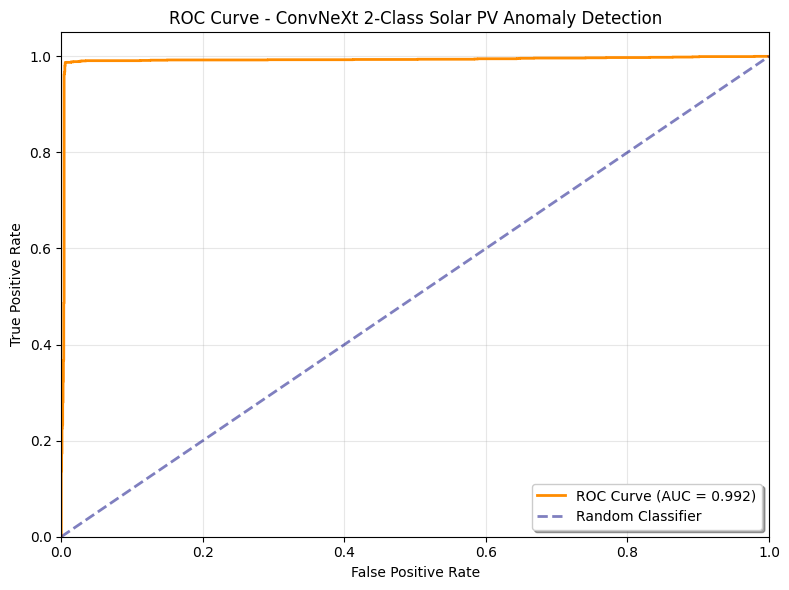


🎯 Optimal Operating Point (Youden's J):
  Threshold: 0.5336
  True Positive Rate: 0.9865
  False Positive Rate: 0.0055
  J-Score: 0.9810

📈 ROC/AUC Analysis Summary:
  AUC Score: 0.9917 (Excellent performance)
  Model discriminates between Anomaly and No-Anomaly classes

💾 ROC/AUC results saved to:
  📊 Plot: results\2_class_pytorch/roc_curve_convnext_2class.png
  📄 Data: results\2_class_pytorch/roc_auc_results_convnext_2class.json
✅ ROC/AUC analysis for 2-class solar PV anomaly detection completed!


In [15]:
# ROC/AUC Analysis for 2-Class Classification
print("\n" + "="*80)
print("📈 ROC/AUC Analysis for 2-Class Classification")
print("="*80)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and probabilities for ROC analysis
print("🔄 Computing ROC curves and AUC scores...")

# Load the best model for evaluation
if os.path.exists(RESULTS_PATH / 'best_convnext_2class_stratified.pth'):
    model.load_state_dict(torch.load(RESULTS_PATH / 'best_convnext_2class_stratified.pth', map_location=device))
    print("✅ Best model loaded for ROC analysis")
else:
    print("⚠️ Using current model state for ROC analysis")

model.eval()
all_predictions = []
all_probabilities = []
all_targets = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Computing probabilities"):
        data, target = data.to(device), target.to(device)
        output = model(data)
        probabilities = torch.softmax(output, dim=1)
        
        all_probabilities.extend(probabilities.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

all_probabilities = np.array(all_probabilities)
all_targets = np.array(all_targets)

# For 2-class classification, we use the probability of the positive class (Anomaly)
# Assuming class 0 = Anomaly, class 1 = No-Anomaly
y_scores = all_probabilities[:, 0]  # Probability of Anomaly class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_targets, y_scores, pos_label=0)
roc_auc = auc(fpr, tpr)

# Print AUC score
print("\n📊 AUC Score for 2-Class Solar PV Anomaly Detection:")
print("-" * 60)
print(f"{'Anomaly vs No-Anomaly':25s}: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5, 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ConvNeXt 2-Class Solar PV Anomaly Detection')
plt.legend(loc="lower right", fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_PATH / 'roc_curve_convnext_2class.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

print(f"\n🎯 Optimal Operating Point (Youden's J):")
print(f"  Threshold: {optimal_threshold:.4f}")
print(f"  True Positive Rate: {optimal_tpr:.4f}")
print(f"  False Positive Rate: {optimal_fpr:.4f}")
print(f"  J-Score: {j_scores[optimal_idx]:.4f}")

# Save ROC/AUC results
roc_auc_results = {
    'auc_score': float(roc_auc),
    'class_names': full_dataset.classes,
    'optimal_threshold': {
        'threshold': float(optimal_threshold),
        'true_positive_rate': float(optimal_tpr),
        'false_positive_rate': float(optimal_fpr),
        'j_score': float(j_scores[optimal_idx])
    },
    'roc_curve': {
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'thresholds': thresholds.tolist()
    },
    'analysis_type': '2-class_solar_pv_anomaly_detection'
}

with open(RESULTS_PATH / 'roc_auc_results_convnext_2class.json', 'w') as f:
    json.dump(roc_auc_results, f, indent=4)

# Performance interpretation
print(f"\n📈 ROC/AUC Analysis Summary:")
if roc_auc >= 0.9:
    performance = "Excellent"
elif roc_auc >= 0.8:
    performance = "Good"
elif roc_auc >= 0.7:
    performance = "Fair"
else:
    performance = "Poor"

print(f"  AUC Score: {roc_auc:.4f} ({performance} performance)")
print(f"  Model discriminates between Anomaly and No-Anomaly classes")

print(f"\n💾 ROC/AUC results saved to:")
print(f"  📊 Plot: {RESULTS_PATH}/roc_curve_convnext_2class.png")
print(f"  📄 Data: {RESULTS_PATH}/roc_auc_results_convnext_2class.json")
print("✅ ROC/AUC analysis for 2-class solar PV anomaly detection completed!")
